<a href="https://colab.research.google.com/github/zhou100/FoodSecurityPrediction/blob/master/Predict_FS_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use machine learning to predict food security

In [0]:
# Set up Notebook
% matplotlib inline

# Standard imports
from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from matplotlib import cm


# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

 ## Read in the data cleaned out by R

If you are using google colab like me, you will need to mount your google drive first and  copy the cleaned dataset from the R project to your google drive. 

If you are using python/jupyter notebook locally, just point to the right directory. 

In [0]:
# mw_clust= pd.read_csv("data/clean/dataset/mw_dataset_cluster.csv")

url = 'https://raw.githubusercontent.com/zhou100/FoodSecurityPrediction/master/data/clean/dataset/mw_dataset_cluster.csv'
mw_clust = pd.read_csv(url)

In [0]:
url_tz = 'https://raw.githubusercontent.com/zhou100/FoodSecurityPrediction/master/data/clean/dataset/tz_dataset_cluster.csv'
tz_clust = pd.read_csv(url_tz)

In [167]:
url_ug = 'https://raw.githubusercontent.com/zhou100/FoodSecurityPrediction/master/data/clean/dataset/ug_dataset_cluster.csv'
ug_clust = pd.read_csv(url_ug)
ug_clust = ug_clust.replace([np.inf, -np.inf], np.nan)
ug_clust = ug_clust.dropna()
ug_clust.isnull().values.any()

False

## Preprocessing data


### One-hot encoding for string variables 

In [0]:
mw_clust["FNID"]= mw_clust["FNID"].str.lstrip('MW2012C')
fnid_mw_clust = pd.get_dummies(mw_clust["FNID"],prefix='MW', drop_first=True)
mw_clust = pd.concat([mw_clust, fnid_mw_clust], axis=1)

In [14]:
mw_clust.head()

,FS_year,FNID,FCS,HDDS,rCSI,region_north,region_central,rural,dist_road,dist_admarc,dist_popcenter,percent_ag,nutri_severe_constraint,nutri_moderate_constraint,nutri_reten_severe_constraint,dummy_terrain_rough,FS_month,head_age,female_head,hhsize,floor_dirt_sand_dung,cell_phone,number_celphones,roof_not_natural,roof_iron,asset_index,clust_maize_price,clust_rice_price,clust_nuts_price,clust_beans_price,clust_maize_mktthin,clust_rice_mktthin,clust_nuts_mktthin,clust_beans_mktthin,lhz_maize_price,lhz_rice_price,lhz_nuts_price,lhz_beans_price,lhz_maize_mktthin,lhz_rice_mktthin,...,MW_3020213,MW_3020303,MW_3020403,MW_3020503,MW_3020513,MW_3020515,MW_3020603,MW_3020619,MW_3020703,MW_3020803,MW_3020813,MW_3020815,MW_3020913,MW_3030112,MW_3030114,MW_3030115,MW_3030204,MW_3030206,MW_3030214,MW_3030304,MW_3030306,MW_3030314,MW_3030404,MW_3030414,MW_3030506,MW_3030514,MW_3030519,MW_3030606,MW_3030613,MW_3030714,MW_3030716,MW_3030804,MW_3030816,MW_3030904,MW_3031005,MW_3031105,MW_3031206,MW_3031213,MW_3031313,MW_3999918
0,2010,3010102,42.718750,5.375000,2.750000,1.0,0.0,1.000000,2.656875,12.016250,62.406875,20.875000,0.000000,1.000000,0.0,0,4.000000,45.375000,0.187500,5.937500,0.937500,0.250000,0.437500,0.125000,0.125000,-0.409163,44.282500,247.276000,235.426000,187.412000,0.2,0.0,0.0,0.0,51.144094,194.816929,233.930246,167.089217,0.400000,0.4,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2013,3010102,41.500000,4.687500,11.625000,1.0,0.0,1.000000,2.250000,12.687500,62.562500,23.250000,0.000000,1.000000,0.0,0,4.000000,47.937500,0.250000,6.187500,0.937500,0.250000,0.250000,0.062500,0.062500,-0.587467,117.495000,338.092614,260.726301,169.705691,0.5,1.0,1.0,1.0,145.347005,390.687644,237.306038,271.791314,0.500000,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2010,3010102,35.218750,4.937500,2.687500,1.0,0.0,1.000000,0.513750,10.821875,58.466875,48.687500,0.000000,1.000000,0.0,0,8.000000,43.187500,0.062500,5.437500,0.875000,0.250000,0.250000,0.187500,0.187500,-0.373761,31.591000,176.821000,180.817000,167.261000,0.0,0.0,0.0,0.0,30.082676,141.357511,92.399333,144.797615,1.000000,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2010,3010508,35.218750,4.937500,2.687500,1.0,0.0,1.000000,0.513750,10.821875,58.466875,48.687500,0.000000,1.000000,0.0,0,8.000000,43.187500,0.062500,5.437500,0.875000,0.250000,0.250000,0.187500,0.187500,-0.373761,31.591000,176.821000,180.817000,167.261000,0.0,0.0,0.0,0.0,30.082676,141.357511,92.399333,144.797615,1.000000,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2013,3010102,48.088235,5.058824,2.411765,1.0,0.0,0.941176,0.529412,11.411765,56.529412,45.764706,0.058824,0.941176,0.0,0,5.058824,45.647059,0.176471,5.529412,0.823529,0.411765,0.647059,0.352941,0.352941,-0.322886,119.627402,400.969080,379.379586,347.946196,0.0,1.0,1.0,1.0,96.706535,257.533827,244.449981,231.704856,0.627451,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
tz_clust.head()

,FS_year,FCS,HDDS,rCSI,rural,FS_month,region2,region3,region4,region5,region6,region7,region8,region9,region10,region11,region12,region13,region14,region15,region16,region17,region18,region19,region20,region21,region51,region52,region53,region54,region55,dist_road,dist_popcenter,percent_ag,nutri_severe_constraint,nutri_moderate_constraint,nutri_reten_severe_constraint,dummy_terrain_rough,head_age,female_head,asset_index,Cellphone,num_cell,floor_dirt_sand_dung,roof_not_natural,roof_iron,clust_maize_price,clust_rice_price,clust_bean_mktthin,clust_maize_mktthin,clust_rice_mktthin,lhz_maize_price,lhz_rice_price,lhz_bean_mktthin,lhz_maize_mktthin,lhz_rice_mktthin,raincytot,day1rain,maxdaysnorain,lhz_day1rain,gdd,tmean,lhz_raincytot,lhz_maxdaysnorain,heatdays,floodmax,lhz_floodmax,FCS_category,HDDS_category
0,2015,43.375000,5.250000,6.125,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.464894,32.893617,32.898936,0.606383,0.313830,0.005319,0,41.375000,0.250000,-0.765501,0.625000,0.875000,0.625000,0.625000,0.625000,27708.0,175833.0,0.0,0.0,0.0,44926.970174,175166.466099,0.0,0.0,0.0,949.138410,5,148,81,213,27.410465,701.392269,142,213,0.0,0.0,0,1
1,2015,33.562500,4.500000,17.750,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.464894,32.893617,32.898936,0.606383,0.313830,0.005319,0,46.000000,0.125000,-0.886329,0.500000,0.500000,1.000000,0.000000,0.000000,21731.0,161538.0,0.0,0.0,0.0,38137.865269,156000.969581,0.0,0.0,0.0,948.396418,5,117,81,213,27.410465,701.392269,142,213,0.0,0.0,1,1
2,2014,34.000000,4.000000,0.000,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.142582,50.944231,23.662088,0.054945,0.708791,0.000000,0,57.000000,0.000000,-0.583524,0.000000,0.000000,1.000000,1.000000,1.000000,34125.0,154166.5,0.0,0.0,0.0,34493.312488,153017.457084,0.0,0.0,0.0,1008.294152,56,154,56,213,23.074113,1057.404969,122,213,0.0,0.0,1,1
3,2015,40.642857,4.142857,2.000,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.142582,50.944231,23.662088,0.054945,0.708791,0.000000,0,44.428571,0.571429,-0.895485,0.857143,1.285714,0.857143,0.571429,0.571429,33000.0,172778.0,0.0,0.0,0.0,33426.151812,171574.642544,0.0,0.0,0.0,946.519706,5,148,51,213,24.746366,779.541637,125,213,0.0,0.0,1,1
4,2015,53.625000,5.000000,9.375,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.661765,70.922549,19.411765,0.009804,0.774510,0.000000,0,50.625000,0.250000,0.050865,1.000000,1.875000,0.125000,1.000000,1.000000,33000.0,172778.0,0.0,0.0,0.0,33000.000000,172778.000000,0.0,0.0,0.0,922.248186,5,117,50,213,24.762482,807.468836,123,213,0.0,0.0,0,1


In [16]:
ug_clust['FCS_category']= pd.cut(x=ug_clust['FCS'], bins=[-1,28,42,200],labels= [2, 1, 0])
ug_clust['HDDS_category']= pd.cut(x=ug_clust['HDDS'], bins=[-1,3,6,20],labels= [2, 1, 0])

ug_clust.isnull().values.any()

False

In [17]:
ug_clust.head()

,FS_year,FNID,FCS,HDDS,rural,FS_month,region2,region3,region4,dist_road,dist_popcenter,percent_ag,nutri_severe_constraint,nutri_moderate_constraint,nutri_reten_severe_constraint,dummy_terrain_rough,head_age,female_head,asset_index,Cellphone,num_cell,floor_dirt_sand_dung,roof_not_natural,roof_iron,clust_cassava_price,clust_bean_mktthin,clust_maize_mktthin,clust_cassava_mktthin,lhz_cassava_price,lhz_bean_mktthin,lhz_maize_mktthin,lhz_cassava_mktthin,raincytot,day1rain,maxdaysnorain,lhz_day1rain,gdd,tmean,lhz_raincytot,lhz_maxdaysnorain,floodmax,lhz_floodmax,FCS_category,HDDS_category
0,2010,UG2011L141,47.5,3.0,0.0,12.0,0.0,0.0,0.0,0.81360,4.09120,22.0,0.0,1.0,0.0,0,31.0,0.0,1.933340,1.0,3.0,0.0,1.0,1.0,600.0,1.0,1.0,0.0,593.592838,1.00000,1.00000,0.000000,474.492036,3,28,3,123,25.129216,558.706113,2,0.0,0.0,0,2
1,2011,UG2011L141,20.0,3.0,1.0,1.0,0.0,0.0,0.0,40.43450,65.52810,0.0,0.0,0.0,0.0,0,45.0,0.0,-1.270643,1.0,1.0,1.0,1.0,1.0,900.0,1.0,1.0,0.0,702.971126,1.00000,1.00000,0.028336,1823.754595,3,143,3,488,23.691104,1866.829980,18,0.0,0.0,2,2
2,2012,UG2011L137,52.0,5.4,1.0,4.0,0.0,0.0,0.0,24.63892,48.91718,19.8,0.2,0.2,0.2,0,36.2,0.4,-0.033716,0.8,0.8,0.8,1.0,1.0,1193.6,0.0,0.0,0.0,1197.521782,0.01498,0.01498,0.014980,2040.792751,17,40,14,489,23.937279,1939.734309,24,0.0,0.0,0,1
3,2012,UG2011L140,52.0,5.4,1.0,4.0,0.0,0.0,0.0,24.63892,48.91718,19.8,0.2,0.2,0.2,0,36.2,0.4,-0.033716,0.8,0.8,0.8,1.0,1.0,1193.6,0.0,0.0,0.0,1197.521782,0.01498,0.01498,0.014980,2040.792751,17,40,5,489,23.030044,1967.415063,22,0.0,0.0,0,1
4,2012,UG2011L141,52.0,5.4,1.0,4.0,0.0,0.0,0.0,24.63892,48.91718,19.8,0.2,0.2,0.2,0,36.2,0.4,-0.033716,0.8,0.8,0.8,1.0,1.0,1193.6,0.0,0.0,0.0,1197.521782,0.01498,0.01498,0.014980,2040.792751,17,40,5,489,23.658749,2223.933356,13,0.0,0.0,0,1


In [0]:
ug_clust = ug_clust.drop("FNID",axis =1 )

In [19]:
ug_clust.isnull().values.any()

False

# Methodology


This section will explain our main approach with the data.

1. Focus on categorical prediciton for the given cutoffs. 

Reasons: Close to the actual policy scenarios where we focus on capturing all the insecure households. Recall rate of the insecure villages is more important than the over all accuracy. 

Can apply the down sampling and over sampling technique here to improve 


2.  Algorithms to try : tree classifier, random forest classifier, xgboost 

2.1. By categories, vs one or rest

2.2.  Parameter Tuning

2.3 . feature importance analysis


3.  Error analysis by region, by group, by month

4.  Train model by division separtely Auto-segmentation by training a shallow tree in each country based on observables 

5. Model combination: what happens when we train on all the data 

6. Model generalization issues: what happens when we directly apply  models trained on one country to predict another 







## Exploratory Data Analysis  

### Measures:  plot target measures by year by country


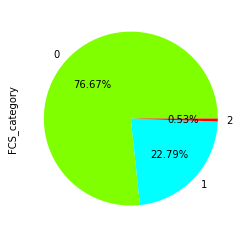

In [176]:
# cut the outcome variables by the cutoffs
#mw_clust['FCS_category']= pd.cut(x=mw_clust['FCS'], bins=[-1,28,42,100],labels= ["Poor", "Borderline", "Acceptable"])
mw_clust['FCS_category']= pd.cut(x=mw_clust['FCS'], bins=[-1,28,42,100],labels= [2, 1, 0])

mw_clust['FCS_category'].value_counts().plot(kind='pie', title='',autopct = "%.2f%%", colors = ['chartreuse', 'aqua','red'])


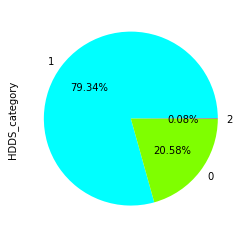

In [177]:


 # HDDS 3 and 6
#mw_clust['HDDS_category']= pd.cut(x=mw_clust['HDDS'], bins=[0,3,6,10],labels= ["Low Diversity","Medium Diversity","Good Diversity"])
mw_clust['HDDS_category']= pd.cut(x=mw_clust['HDDS'], bins=[0,3,6,10],labels= [2, 1, 0])
  
mw_clust['HDDS_category'].value_counts().plot(kind='pie', title='',autopct = "%.2f%%", colors = ['aqua','chartreuse','red'])

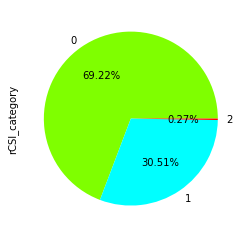

In [178]:


# rCSI 4 and 17  and 42
# mw_clust['rCSI_category']= pd.cut(x=mw_clust['rCSI'], bins=[-1,4,17,42],labels= ["Food Secure","Mildly insecure","Moderately insecure"])
  
mw_clust['rCSI_category']= pd.cut(x=mw_clust['rCSI'], bins=[-1,4,17,42],labels= [0, 1, 2])
  
mw_clust['rCSI_category'].value_counts().plot(kind='pie', title='',autopct = "%.2f%%", colors = ['chartreuse','aqua','red'])




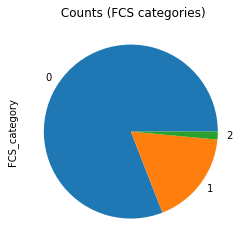

In [175]:
# cut the outcome variables by the cutoffs
tz_clust['FCS_category']= pd.cut(x=tz_clust['FCS'], bins=[-1,28,42,200],labels= [2, 1, 0])

tz_clust['FCS_category'].value_counts().plot(kind='pie', title=' Counts (FCS categories)')


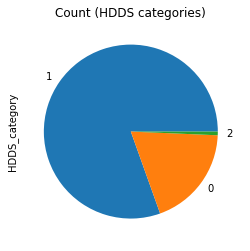

In [174]:
# HDDS 3 and 6
tz_clust['HDDS_category']= pd.cut(x=tz_clust['HDDS'], bins=[-1,3,6,20],labels= [2, 1, 0])

tz_clust['HDDS_category'].value_counts().plot(kind='pie', title='Count (HDDS categories)')


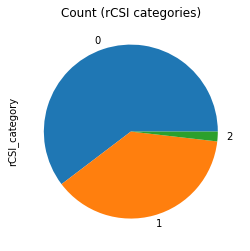

In [173]:
# rCSI 4 and 17  and 42
tz_clust['rCSI_category']= pd.cut(x=tz_clust['rCSI'], bins=[-1,4,17,43],labels= [0, 1, 2])

tz_clust['rCSI_category'].value_counts().plot(kind='pie', title='Count (rCSI categories)')


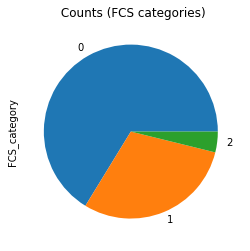

In [172]:
# cut the outcome variables by the cutoffs
ug_clust['FCS_category']= pd.cut(x=ug_clust['FCS'], bins=[-1,28,42,200],labels= [2, 1, 0])

ug_clust['FCS_category'].value_counts().plot(kind='pie', title=' Counts (FCS categories)')




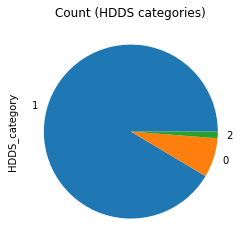

In [171]:
# HDDS 3 and 6
ug_clust['HDDS_category']= pd.cut(x=ug_clust['HDDS'], bins=[-1,3,6,20],labels= [2, 1, 0])

ug_clust['HDDS_category'].value_counts().plot(kind='pie', title='Count (HDDS categories)')

 

## Split train and test data

 For practical prediction purposes,  we use the most recent round of survey data  as the testing  and the rest as the training data. 


### Year split 

In [0]:
mw_clust_test_cond =  mw_clust['FS_year']>2015
mw_clust_train_cond =  mw_clust['FS_year']<2016
mw_clust_test = mw_clust[mw_clust_test_cond]
mw_clust_train = mw_clust[mw_clust_train_cond]


tz_clust_test_cond =  tz_clust['FS_year']>2013
tz_clust_train_cond =  tz_clust['FS_year']<2014
tz_clust_test = tz_clust[tz_clust_test_cond]
tz_clust_train = tz_clust[tz_clust_train_cond]

ug_clust_test_cond =  ug_clust['FS_year']>2011
ug_clust_train_cond =  ug_clust['FS_year']<2012
ug_clust_test = ug_clust[ug_clust_test_cond]
ug_clust_train = ug_clust[ug_clust_train_cond]


# Define label variables  
labels = ['FCS', 'rCSI', 'HDDS']
category_labels = ['FCS_category', 'rCSI_category', 'HDDS_category']


# Separate y and X

mw_clust_y_train= mw_clust_train[['FCS_category', 'rCSI_category', 'HDDS_category']]
mw_clust_y_test= mw_clust_test[['FCS_category', 'rCSI_category', 'HDDS_category']]
 
mw_clust_X_test= mw_clust_test.drop(labels+category_labels+['FNID'],  axis=1)
mw_clust_X_train= mw_clust_train.drop(labels+category_labels+['FNID'], axis=1)


tz_clust_y_train= tz_clust_train[['FCS_category', 'rCSI_category', 'HDDS_category']]
tz_clust_y_test= tz_clust_test[['FCS_category', 'rCSI_category', 'HDDS_category']]

tz_clust_X_test= tz_clust_test.drop(labels+category_labels,  axis=1)
tz_clust_X_train= tz_clust_train.drop(labels+category_labels, axis=1)


ug_clust_y_train= ug_clust_train[['FCS_category', 'HDDS_category']]
ug_clust_y_test= ug_clust_test[['FCS_category', 'HDDS_category']]

ug_clust_X_test= ug_clust_test.drop(['FCS_category', 'FCS', 'HDDS', 'HDDS_category'],  axis=1)
ug_clust_X_train= ug_clust_train.drop(['FCS_category', 'FCS', 'HDDS', 'HDDS_category'],axis=1)


### Region split

In [0]:
mw_clust_test_cond_region =  mw_clust['region_central']>0.7
mw_clust_train_cond_region =  mw_clust['region_central']<0.7

mw_clust_test_region = mw_clust[mw_clust_test_cond_region]
mw_clust_train_region = mw_clust[mw_clust_train_cond_region]



In [0]:
ug_clust_test_cond_region1 =  ug_clust['region4']==0 
ug_clust_test_cond_region2 =  ug_clust['region3']==0 
ug_clust_test_cond_region3 =  ug_clust['region2']==0 

ug_clust_train_cond_region1 =  ug_clust['region4']!=0 
ug_clust_train_cond_region2 =  ug_clust['region3']!=0 
ug_clust_train_cond_region3 =  ug_clust['region2']!=0 


ug_clust_test_region = ug_clust[ug_clust_test_cond_region1 & ug_clust_test_cond_region2 & ug_clust_test_cond_region3]
ug_clust_train_region = ug_clust[ ug_clust_train_cond_region1 | ug_clust_train_cond_region2 | ug_clust_train_cond_region3 ]


In [139]:
ug_clust_test_region.shape

(450, 43)

In [0]:


# Define label variables  
labels = ['FCS', 'rCSI', 'HDDS']
category_labels = ['FCS_category', 'rCSI_category', 'HDDS_category']


# Separate y and X

mw_clust_y_train_region= mw_clust_train_region[['FCS_category', 'rCSI_category', 'HDDS_category']]
mw_clust_y_test_region= mw_clust_test_region[['FCS_category', 'rCSI_category', 'HDDS_category']]
 
mw_clust_X_test_region= mw_clust_test_region.drop(labels+category_labels+['FNID'],  axis=1)
mw_clust_X_train_region= mw_clust_train_region.drop(labels+category_labels+['FNID'], axis=1)


 

ug_clust_y_train_region= ug_clust_train_region[['FCS_category', 'HDDS_category']]
ug_clust_y_test_region= ug_clust_test_region[['FCS_category', 'HDDS_category']]

ug_clust_X_test_region= ug_clust_test_region.drop(['FCS_category', 'FCS', 'HDDS', 'HDDS_category'],  axis=1)
ug_clust_X_train_region= ug_clust_train_region.drop(['FCS_category', 'FCS', 'HDDS', 'HDDS_category'],axis=1)
 

### Random split

In [0]:
### Random split

from sklearn.model_selection import train_test_split




y_mw = mw_clust[['FCS_category', 'rCSI_category', 'HDDS_category']]

X_mw = mw_clust.drop(labels+category_labels+['FNID'],  axis=1)



X_train_mw, X_test_mw, y_train_mw, y_test_mw = train_test_split(X_mw, y_mw, test_size=0.33, random_state=42)




y_ug = ug_clust[['FCS_category', 'HDDS_category']]

X_ug = ug_clust.drop(['FCS_category', 'FCS', 'HDDS', 'HDDS_category','FNID'],  axis=1)



X_train_ug, X_test_ug, y_train_ug, y_test_ug = train_test_split(X_ug, y_ug, test_size=0.33, random_state=42)






## Baseline models



### Define models

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report


def TreeCLF(X_train,y_train,X_test, y_test):
    # Define tree classifier
    tree_clf = DecisionTreeClassifier(random_state=66)
    
    max_depth = [int(x) for x in np.linspace(3, 20, num = 10)]
    max_features = [int(x) for x in np.linspace(3, 20, num = 10)]
    # n_estimators = [int(x) for x in np.linspace(1, 10, num = 5)]

    random_grid = {#'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth
                   #'min_samples_split': min_samples_split
                   #'min_samples_leaf': min_samples_leaf}
                   #'bootstrap': bootstrap
                    }
    
    tree_random = RandomizedSearchCV(estimator = tree_clf, param_distributions = random_grid,
                                    n_iter = 30, cv = 3, verbose=2, random_state=666, n_jobs = -1)


    tree_random.fit( X_train, y_train)

    y_pred = tree_random.predict(X_test)
    
    # report = classification_report(y_test, y_pred)

    
    # Return accuracy
    tree_test_score = round(tree_random.score(X_test, y_test), 3)
    tree_train_score = round(tree_random.score(X_train, y_train), 3)
    
    
    
    return y_pred,y_test
    # return tree_random 
    # return report

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report


def rfCLF(X_train,y_train,X_test, y_test):

    rf_clf = RandomForestClassifier(max_features='auto', n_estimators = 100,min_samples_split=10,warm_start=True)

        
    # Define rfc classifier
    max_depth = [int(x) for x in np.linspace(3, 20, num = 10)]
    max_features = [int(x) for x in np.linspace(3, 20, num = 10)]

    random_grid = {#'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth
                   #'min_samples_split': min_samples_split
                   #'min_samples_leaf': min_samples_leaf}
                   #'bootstrap': bootstrap
                    }
    
    rf_random = RandomizedSearchCV(estimator = rf_clf, param_distributions = random_grid,
                                    n_iter = 30, cv = 3, verbose=2, random_state=666, n_jobs = -1)


    # Fit the random search model
    rf_random.fit(X_train, y_train)

    # Return accuracy
#     rf_test_score = round(rf_random.score(X_test, y_test), 3)
#     rf_train_score = round(rf_random.score(X_train, y_train), 3)
    
    y_pred = rf_random.predict(X_test)
    

    # return rf_test_score 
    return y_pred,y_test

In [0]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report


def XGBCLF(X_train,y_train,X_test, y_test):

    # fit model on  training data
    XGB_clf = XGBClassifier(silent=False, 
                          scale_pos_weight=1,
                          learning_rate=0.3,  
                          colsample_bytree = 0.4,
                          subsample = 0.8,
                          objective='binary:logistic', 
                          #objective='multi:softmax', 
                          #num_class=14,
                          n_estimators=100, 
                          reg_alpha = 0.3,
                          max_depth=5, 
                          gamma=10)
    
    max_depth = [int(x) for x in np.linspace(3, 20, num = 10)]
    max_features = [int(x) for x in np.linspace(3, 20, num = 10)]

    random_grid = {#'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth
                   #'min_samples_split': min_samples_split
                   #'min_samples_leaf': min_samples_leaf}
                   #'bootstrap': bootstrap
                    }
    
    XGB_random = RandomizedSearchCV(estimator = XGB_clf, param_distributions = random_grid,
                                    n_iter = 30, cv = 3, verbose=2, random_state=666, n_jobs = -1)


    
    # Fit the random search model
    XGB_random.fit(X_train, y_train)

    # Return accuracy
    xgb_test_score = round(XGB_random.score(X_test, y_test), 3)
    xgb_train_score = round(XGB_random.score(X_train, y_train), 3)
    
    # return xgb_test_score
    
    y_pred = XGB_random.predict(X_test)
    

    # return rf_test_score 
    return y_pred,y_test


### Tree models

In [43]:
#y_pred,y_test = TreeCLF (mw_clust_X_train,mw_clust_y_train['FCS_category'], mw_clust_X_test,mw_clust_y_test['FCS_category'] )

tree_model = TreeCLF (mw_clust_X_train,mw_clust_y_train['FCS_category'], mw_clust_X_test,mw_clust_y_test['FCS_category'] )

# print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.8s finished


In [50]:
# tree_model.best_params_

tree_clf = DecisionTreeClassifier(random_state=66,max_depth=3,max_features= 14)
tree_clf.fit(mw_clust_X_train,mw_clust_y_train['FCS_category'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=14, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=66, splitter='best')

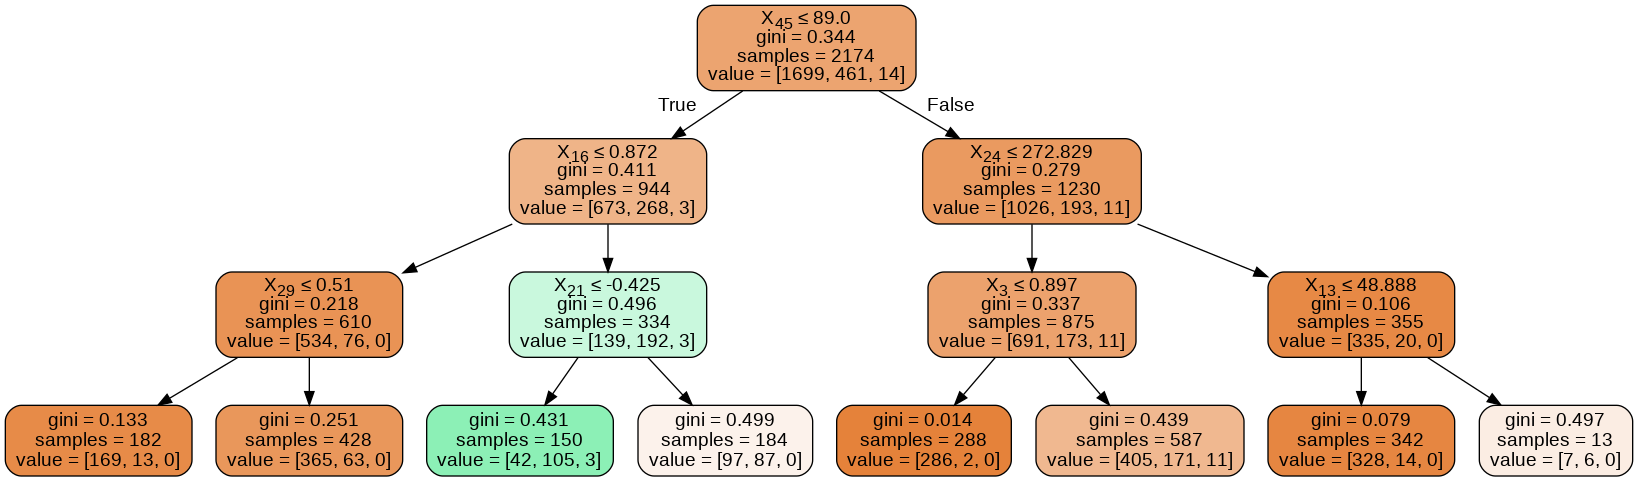

In [51]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(tree_clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [61]:
mw_clust_X_train.columns[13]

'head_age'

In [39]:
y_pred,y_test  = TreeCLF (mw_clust_X_train,mw_clust_y_train['HDDS_category'], mw_clust_X_test,mw_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: ignored

In [38]:
y_pred,y_test  = TreeCLF (mw_clust_X_train,mw_clust_y_train['rCSI_category'], mw_clust_X_test,mw_clust_y_test['rCSI_category'] )
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.33      0.69      0.45       157
           1       0.55      0.23      0.33       282
           2       0.00      0.00      0.00         6

    accuracy                           0.39       445
   macro avg       0.30      0.31      0.26       445
weighted avg       0.47      0.39      0.37       445



[Parallel(n_jobs=-1)]: Done  87 out of  90 | elapsed:    2.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.8s finished


### ML models baseline

In [0]:
y_pred,y_test  =  rfCLF (mw_clust_X_train,mw_clust_y_train['FCS_category'], mw_clust_X_test,mw_clust_y_test['FCS_category'] )
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   18.0s finished


              precision    recall  f1-score   support

           0       0.69      1.00      0.82       309
           1       0.00      0.00      0.00       136

    accuracy                           0.69       445
   macro avg       0.35      0.50      0.41       445
weighted avg       0.48      0.69      0.57       445



In [37]:
y_pred,y_test  = rfCLF (mw_clust_X_train,mw_clust_y_train['HDDS_category'], mw_clust_X_test,mw_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: ignored

In [0]:
y_pred,y_test  =  rfCLF (mw_clust_X_train,mw_clust_y_train['rCSI_category'], mw_clust_X_test,mw_clust_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   19.0s finished


              precision    recall  f1-score   support

           0       0.39      0.93      0.55       157
           1       0.78      0.20      0.32       282
           2       0.00      0.00      0.00         6

    accuracy                           0.45       445
   macro avg       0.39      0.38      0.29       445
weighted avg       0.63      0.45      0.39       445



In [0]:
y_pred,y_test  = XGBCLF (mw_clust_X_train,mw_clust_y_train['FCS_category'], mw_clust_X_test,mw_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.7min finished


              precision    recall  f1-score   support

           0       0.69      1.00      0.82       309
           1       0.00      0.00      0.00       136

    accuracy                           0.69       445
   macro avg       0.35      0.50      0.41       445
weighted avg       0.48      0.69      0.57       445



In [0]:
y_pred,y_test  =  XGBCLF (mw_clust_X_train,mw_clust_y_train['HDDS_category'], mw_clust_X_test,mw_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.3min finished


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.66      0.79       445

    accuracy                           0.66       445
   macro avg       0.50      0.33      0.40       445
weighted avg       1.00      0.66      0.79       445



In [0]:
y_pred,y_test  =  XGBCLF (mw_clust_X_train,mw_clust_y_train['rCSI_category'], mw_clust_X_test,mw_clust_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.3min finished


              precision    recall  f1-score   support

           0       0.59      0.55      0.57       157
           1       0.74      0.79      0.77       282
           2       0.00      0.00      0.00         6

    accuracy                           0.69       445
   macro avg       0.45      0.45      0.45       445
weighted avg       0.68      0.69      0.69       445



In [0]:
y_pred,y_test = TreeCLF (tz_clust_X_train,tz_clust_y_train['FCS_category'], tz_clust_X_test,tz_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = TreeCLF (tz_clust_X_train,tz_clust_y_train['HDDS_category'], tz_clust_X_test,tz_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = TreeCLF (tz_clust_X_train,tz_clust_y_train['rCSI_category'], tz_clust_X_test,tz_clust_y_test['rCSI_category'] )
print(classification_report(y_test, y_pred))


y_pred,y_test  =  rfCLF (tz_clust_X_train,tz_clust_y_train['FCS_category'], tz_clust_X_test,tz_clust_y_test['FCS_category'] )
print(classification_report(y_test, y_pred))

y_pred,y_test  = rfCLF (tz_clust_X_train,tz_clust_y_train['HDDS_category'], tz_clust_X_test,tz_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))


y_pred,y_test  =  rfCLF (tz_clust_X_train,tz_clust_y_train['rCSI_category'], tz_clust_X_test,tz_clust_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred))


y_pred,y_test  = XGBCLF (tz_clust_X_train,tz_clust_y_train['FCS_category'], tz_clust_X_test,tz_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))


y_pred,y_test  =  XGBCLF (tz_clust_X_train,tz_clust_y_train['HDDS_category'], tz_clust_X_test,tz_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  =  XGBCLF (tz_clust_X_train,tz_clust_y_train['rCSI_category'], tz_clust_X_test,tz_clust_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.89      1.00      0.94       342
           1       0.50      0.02      0.04        43
           2       0.00      0.00      0.00         1

    accuracy                           0.89       386
   macro avg       0.46      0.34      0.33       386
weighted avg       0.84      0.89      0.84       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.50      0.02      0.05        82
           1       0.79      0.99      0.88       304

    accuracy                           0.79       386
   macro avg       0.65      0.51      0.46       386
weighted avg       0.73      0.79      0.70       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.65      0.83      0.73       227
           1       0.58      0.37      0.45       153
           2       0.00      0.00      0.00         6

    accuracy                           0.63       386
   macro avg       0.41      0.40      0.39       386
weighted avg       0.61      0.63      0.61       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   22.1s finished


              precision    recall  f1-score   support

           0       0.89      1.00      0.94       342
           1       0.00      0.00      0.00        43
           2       0.00      0.00      0.00         1

    accuracy                           0.89       386
   macro avg       0.30      0.33      0.31       386
weighted avg       0.79      0.89      0.83       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   22.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        82
           1       0.79      1.00      0.88       304

    accuracy                           0.79       386
   macro avg       0.39      0.50      0.44       386
weighted avg       0.62      0.79      0.69       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   22.9s finished


              precision    recall  f1-score   support

           0       0.64      0.88      0.74       227
           1       0.57      0.28      0.38       153
           2       0.00      0.00      0.00         6

    accuracy                           0.63       386
   macro avg       0.40      0.39      0.37       386
weighted avg       0.60      0.63      0.58       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.3min finished


              precision    recall  f1-score   support

           0       0.91      0.96      0.93       342
           1       0.41      0.21      0.28        43
           2       0.00      0.00      0.00         1

    accuracy                           0.88       386
   macro avg       0.44      0.39      0.40       386
weighted avg       0.85      0.88      0.86       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.2min finished


              precision    recall  f1-score   support

           0       0.58      0.23      0.33        82
           1       0.82      0.95      0.88       304

    accuracy                           0.80       386
   macro avg       0.70      0.59      0.61       386
weighted avg       0.77      0.80      0.77       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.4min finished


              precision    recall  f1-score   support

           0       0.65      0.81      0.73       227
           1       0.56      0.38      0.45       153
           2       0.00      0.00      0.00         6

    accuracy                           0.63       386
   macro avg       0.41      0.40      0.39       386
weighted avg       0.61      0.63      0.61       386



In [0]:
y_pred,y_test = TreeCLF (ug_clust_X_train,ug_clust_y_train['FCS_category'], ug_clust_X_test,ug_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = TreeCLF (ug_clust_X_train,ug_clust_y_train['HDDS_category'], ug_clust_X_test,ug_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))


y_pred,y_test  =  rfCLF (ug_clust_X_train,ug_clust_y_train['FCS_category'], ug_clust_X_test,ug_clust_y_test['FCS_category'] )
print(classification_report(y_test, y_pred))

y_pred,y_test  = rfCLF (ug_clust_X_train,ug_clust_y_train['HDDS_category'], ug_clust_X_test,ug_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))



y_pred,y_test  = XGBCLF (ug_clust_X_train,ug_clust_y_train['FCS_category'], ug_clust_X_test,ug_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))


y_pred,y_test  =  XGBCLF (ug_clust_X_train,ug_clust_y_train['HDDS_category'], ug_clust_X_test,ug_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))



Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.82      0.86      0.84       334
           1       0.42      0.37      0.39        97
           2       1.00      0.11      0.20         9

    accuracy                           0.74       440
   macro avg       0.74      0.45      0.48       440
weighted avg       0.73      0.74      0.73       440

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       0.88      1.00      0.94       389
           2       0.00      0.00      0.00         2

    accuracy                           0.88       440
   macro avg       0.29      0.33      0.31       440
weighted avg       0.78      0.88      0.83       440

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   13.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.80      0.96      0.87       334
           1       0.46      0.16      0.24        97
           2       0.00      0.00      0.00         9

    accuracy                           0.77       440
   macro avg       0.42      0.38      0.37       440
weighted avg       0.70      0.77      0.71       440

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   12.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       0.88      1.00      0.94       389
           2       0.00      0.00      0.00         2

    accuracy                           0.88       440
   macro avg       0.29      0.33      0.31       440
weighted avg       0.78      0.88      0.83       440

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   26.6s finished


              precision    recall  f1-score   support

           0       0.78      0.96      0.86       334
           1       0.41      0.12      0.19        97
           2       0.00      0.00      0.00         9

    accuracy                           0.76       440
   macro avg       0.40      0.36      0.35       440
weighted avg       0.69      0.76      0.70       440

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   18.9s finished


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       0.88      1.00      0.94       389
           2       0.00      0.00      0.00         2

    accuracy                           0.88       440
   macro avg       0.29      0.33      0.31       440
weighted avg       0.78      0.88      0.83       440



In [0]:
ug_clust_y_train.isnull().values.any()

True

In [0]:
tz_clust_X_train.isnull().values.any()

False

## Downsample / oversample 

Using simpler metrics like accuracy_score can be misleading. In a dataset with highly unbalanced classes, if the classifier always "predicts" the most common class without performing any analysis of the features, it will still have a high accuracy rate, obviously illusory.

Resampling
A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling).

Despite the advantage of balancing classes, these techniques also have their weaknesses (there is no free lunch). The simplest implementation of over-sampling is to duplicate random records from the minority class, which can cause overfitting. In under-sampling, the simplest technique involves removing random records from the majority class, which can cause loss of information.



### Oversampling

In [36]:
from sklearn.utils import resample

# concatenate our training data back together
rCSI_df = pd.concat([mw_clust_X_train, mw_clust_y_train['rCSI_category']], axis=1)


rCSI_not_crisis = rCSI_df[rCSI_df.rCSI_category==0]
rCSI_crisis = rCSI_df[rCSI_df.rCSI_category!=0]

# separate minority and majority classes

# upsample minority
rCSI_crisis_upsampled = resample(rCSI_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(rCSI_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
rCSI_upsampled = pd.concat([rCSI_not_crisis, rCSI_crisis_upsampled])

rCSI_upsampled_y_train = rCSI_upsampled["rCSI_category"]

rCSI_upsampled_X_train = rCSI_upsampled.drop("rCSI_category",axis=1)

y_pred,y_test  = rfCLF (rCSI_upsampled_X_train,rCSI_upsampled_y_train, mw_clust_X_test,mw_clust_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = XGBCLF (rCSI_upsampled_X_train,rCSI_upsampled_y_train, mw_clust_X_test,mw_clust_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   26.7s finished


              precision    recall  f1-score   support

           0       0.39      0.96      0.55       157
           1       0.80      0.16      0.26       282
           2       0.00      0.00      0.00         6

    accuracy                           0.44       445
   macro avg       0.40      0.37      0.27       445
weighted avg       0.64      0.44      0.36       445

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.5min finished


              precision    recall  f1-score   support

           0       0.62      0.56      0.59       157
           1       0.75      0.80      0.78       282
           2       0.00      0.00      0.00         6

    accuracy                           0.71       445
   macro avg       0.46      0.46      0.45       445
weighted avg       0.69      0.71      0.70       445



In [0]:
from sklearn.utils import resample

# concatenate our training data back together
HDDS_df = pd.concat([mw_clust_X_train, mw_clust_y_train['HDDS_category']], axis=1)


HDDS_not_crisis = HDDS_df[HDDS_df.HDDS_category==0]
HDDS_crisis = HDDS_df[HDDS_df.HDDS_category!=0]

# separate minority and majority classes

# upsample minority
HDDS_crisis_upsampled = resample(HDDS_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(HDDS_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
HDDS_upsampled = pd.concat([HDDS_not_crisis, HDDS_crisis_upsampled])

HDDS_upsampled_y_train = HDDS_upsampled["HDDS_category"]

HDDS_upsampled_X_train = HDDS_upsampled.drop("HDDS_category",axis=1)

y_pred,y_test  = rfCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, mw_clust_X_test,mw_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = XGBCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, mw_clust_X_test,mw_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   25.3s finished


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.13      0.23       445

    accuracy                           0.13       445
   macro avg       0.50      0.07      0.12       445
weighted avg       1.00      0.13      0.23       445

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.5min finished


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.68      0.81       445

    accuracy                           0.68       445
   macro avg       0.50      0.34      0.40       445
weighted avg       1.00      0.68      0.81       445



In [0]:
from sklearn.utils import resample

# concatenate our training data back together
FCS_df = pd.concat([mw_clust_X_train, mw_clust_y_train['FCS_category']], axis=1)


FCS_not_crisis = FCS_df[FCS_df.FCS_category==0]
FCS_crisis = FCS_df[FCS_df.FCS_category!=0]

# separate minority and majority classes

# upsample minority
FCS_crisis_upsampled = resample(FCS_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(FCS_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
FCS_upsampled = pd.concat([FCS_not_crisis, FCS_crisis_upsampled])

FCS_upsampled_y_train = FCS_upsampled["FCS_category"]

FCS_upsampled_X_train = FCS_upsampled.drop("FCS_category",axis=1)

y_pred,y_test  = rfCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, mw_clust_X_test,mw_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = XGBCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, mw_clust_X_test,mw_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   24.4s finished


              precision    recall  f1-score   support

           0       0.80      0.95      0.87       309
           1       0.82      0.46      0.59       136

    accuracy                           0.80       445
   macro avg       0.81      0.71      0.73       445
weighted avg       0.81      0.80      0.79       445

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.5min finished


              precision    recall  f1-score   support

           0       0.94      0.43      0.59       309
           1       0.42      0.93      0.58       136

    accuracy                           0.59       445
   macro avg       0.68      0.68      0.59       445
weighted avg       0.78      0.59      0.59       445



In [0]:
from sklearn.utils import resample

# concatenate our training data back together
HDDS_df = pd.concat([tz_clust_X_train, tz_clust_y_train['HDDS_category']], axis=1)


HDDS_not_crisis = HDDS_df[HDDS_df.HDDS_category==0]
HDDS_crisis = HDDS_df[HDDS_df.HDDS_category!=0]

# separate minority and majority classes

# upsample minority
HDDS_crisis_upsampled = resample(HDDS_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(HDDS_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
HDDS_upsampled = pd.concat([HDDS_not_crisis, HDDS_crisis_upsampled])

HDDS_upsampled_y_train = HDDS_upsampled["HDDS_category"]

HDDS_upsampled_X_train = HDDS_upsampled.drop("HDDS_category",axis=1)

y_pred,y_test  = rfCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, tz_clust_X_test,tz_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = XGBCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, tz_clust_X_test,tz_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))






Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   13.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.40      0.84      0.55        82
           1       0.94      0.66      0.78       304

    accuracy                           0.70       386
   macro avg       0.67      0.75      0.66       386
weighted avg       0.83      0.70      0.73       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   29.4s finished


              precision    recall  f1-score   support

           0       0.40      0.84      0.54        82
           1       0.94      0.65      0.77       304

    accuracy                           0.69       386
   macro avg       0.67      0.75      0.66       386
weighted avg       0.82      0.69      0.72       386



In [0]:
from sklearn.utils import resample

# concatenate our training data back together
FCS_df = pd.concat([tz_clust_X_train, tz_clust_y_train['FCS_category']], axis=1)


FCS_not_crisis = FCS_df[FCS_df.FCS_category==0]
FCS_crisis = FCS_df[FCS_df.FCS_category!=0]

# separate minority and majority classes

# upsample minority
FCS_crisis_upsampled = resample(FCS_crisis,
                                replace=True, # sample with replacement
                                n_samples=len(FCS_not_crisis), # match number in majority class
                                random_state=27) # reproducible results

# combine majority and upsampled minority
FCS_upsampled = pd.concat([FCS_not_crisis, FCS_crisis_upsampled])

FCS_upsampled_y_train = FCS_upsampled["FCS_category"]

FCS_upsampled_X_train = FCS_upsampled.drop("FCS_category",axis=1)

y_pred,y_test  = rfCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, tz_clust_X_test,tz_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = XGBCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, tz_clust_X_test,tz_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   29.7s finished


              precision    recall  f1-score   support

           0       0.93      0.92      0.92       342
           1       0.39      0.44      0.41        43
           2       0.00      0.00      0.00         1

    accuracy                           0.86       386
   macro avg       0.44      0.45      0.44       386
weighted avg       0.87      0.86      0.86       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.1min finished


              precision    recall  f1-score   support

           0       0.95      0.83      0.89       342
           1       0.32      0.63      0.42        43
           2       0.00      0.00      0.00         1

    accuracy                           0.81       386
   macro avg       0.42      0.49      0.44       386
weighted avg       0.87      0.81      0.83       386



In [0]:
from sklearn.utils import resample

# concatenate our training data back together
rCSI_df = pd.concat([tz_clust_X_train, tz_clust_y_train['rCSI_category']], axis=1)


rCSI_not_crisis = rCSI_df[rCSI_df.rCSI_category==0]
rCSI_crisis = rCSI_df[rCSI_df.rCSI_category!=0]

# separate minority and majority classes

# upsample minority
rCSI_crisis_upsampled = resample(rCSI_crisis,
                                replace=True, # sample with replacement
                                n_samples=len(rCSI_not_crisis), # match number in majority class
                                random_state=27) # reproducible results

# combine majority and upsampled minority
rCSI_upsampled = pd.concat([rCSI_not_crisis, rCSI_crisis_upsampled])

rCSI_upsampled_y_train = rCSI_upsampled["rCSI_category"]

rCSI_upsampled_X_train = rCSI_upsampled.drop("rCSI_category",axis=1)

y_pred,y_test  = rfCLF (rCSI_upsampled_X_train,rCSI_upsampled_y_train, tz_clust_X_test,tz_clust_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = XGBCLF (rCSI_upsampled_X_train,rCSI_upsampled_y_train, tz_clust_X_test,tz_clust_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   25.5s finished


              precision    recall  f1-score   support

           0       0.66      0.78      0.72       227
           1       0.55      0.43      0.49       153
           2       0.00      0.00      0.00         6

    accuracy                           0.63       386
   macro avg       0.41      0.40      0.40       386
weighted avg       0.61      0.63      0.61       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.7min finished


              precision    recall  f1-score   support

           0       0.66      0.74      0.70       227
           1       0.52      0.44      0.48       153
           2       0.00      0.00      0.00         6

    accuracy                           0.61       386
   macro avg       0.39      0.39      0.39       386
weighted avg       0.59      0.61      0.60       386



In [0]:
from sklearn.utils import resample

# concatenate our training data back together
FCS_df = pd.concat([ug_clust_X_train, ug_clust_y_train['FCS_category']], axis=1)


FCS_not_crisis = FCS_df[FCS_df.FCS_category==0]
FCS_crisis = FCS_df[FCS_df.FCS_category!=0]

# separate minority and majority classes

# upsample minority
FCS_crisis_upsampled = resample(FCS_crisis,
                                replace=True, # sample with replacement
                                n_samples=len(FCS_not_crisis), # match number in majority class
                                random_state=27) # reproducible results

# combine majority and upsampled minority
FCS_upsampled = pd.concat([FCS_not_crisis, FCS_crisis_upsampled])

FCS_upsampled_y_train = FCS_upsampled["FCS_category"]

FCS_upsampled_X_train = FCS_upsampled.drop("FCS_category",axis=1)

y_pred,y_test  = rfCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, ug_clust_X_test,ug_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = XGBCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, ug_clust_X_test,ug_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   14.3s finished


              precision    recall  f1-score   support

           0       0.80      0.94      0.87       334
           1       0.44      0.21      0.28        97
           2       1.00      0.11      0.20         9

    accuracy                           0.76       440
   macro avg       0.75      0.42      0.45       440
weighted avg       0.73      0.76      0.72       440

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   32.7s finished


              precision    recall  f1-score   support

           0       0.80      0.93      0.86       334
           1       0.42      0.24      0.30        97
           2       0.00      0.00      0.00         9

    accuracy                           0.75       440
   macro avg       0.41      0.39      0.39       440
weighted avg       0.70      0.75      0.72       440



In [0]:
from sklearn.utils import resample

# concatenate our training data back together
HDDS_df = pd.concat([ug_clust_X_train, ug_clust_y_train['HDDS_category']], axis=1)


HDDS_not_crisis = HDDS_df[HDDS_df.HDDS_category==0]
HDDS_crisis = HDDS_df[HDDS_df.HDDS_category!=0]

# separate minority and majority classes

# upsample minority
HDDS_crisis_upsampled = resample(HDDS_crisis,
                                replace=True, # sample with replacement
                                n_samples=len(HDDS_not_crisis), # match number in majority class
                                random_state=27) # reproducible results

# combine majority and upsampled minority
HDDS_upsampled = pd.concat([HDDS_not_crisis, HDDS_crisis_upsampled])

HDDS_upsampled_y_train = HDDS_upsampled["HDDS_category"]

HDDS_upsampled_X_train = HDDS_upsampled.drop("HDDS_category",axis=1)

y_pred,y_test  = rfCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, ug_clust_X_test,ug_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = XGBCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, ug_clust_X_test,ug_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.37      0.51      0.43        49
           1       0.93      0.89      0.91       389
           2       0.00      0.00      0.00         2

    accuracy                           0.85       440
   macro avg       0.43      0.47      0.45       440
weighted avg       0.86      0.85      0.85       440

Fitting 3 folds for each of 30 candidates, totalling 90 fits
              precision    recall  f1-score   support

           0       0.23      0.73      0.35        49
           1       0.95      0.69      0.80       389
           2       0.00      0.00      0.00         2

    accuracy                           0.69       440
   macro avg       0.39      0.48      0.38       440
weighted avg       0.86      0.69      0.75       440



[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    3.1s finished


### SMOTE  methods

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report


def GBCLF(X_train,y_train,X_test, y_test):

    # fit model on  training data
    GB_clf = GradientBoostingClassifier(
                          
                          learning_rate=0.3,  
                          
                          subsample = 0.8,                    
                          n_estimators=100, 
                          
                          max_depth=5)
    
    max_depth = [int(x) for x in np.linspace(3, 20, num = 10)]
    max_features = [int(x) for x in np.linspace(3, 20, num = 10)]

    random_grid = {#'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth
                   #'min_samples_split': min_samples_split
                   #'min_samples_leaf': min_samples_leaf}
                   #'bootstrap': bootstrap
                    }
    
    GB_random = RandomizedSearchCV(estimator = GB_clf, param_distributions = random_grid,
                                    n_iter = 30, cv = 3, verbose=2, random_state=666, n_jobs = -1)


    
    # Fit the random search model
    GB_random.fit(X_train, y_train)

    # Return accuracy
    gb_test_score = round(GB_random.score(X_test, y_test), 3)
    gb_train_score = round(GB_random.score(X_train, y_train), 3)
    
    # return xgb_test_score
    
    y_pred = GB_random.predict(X_test)
    

    # return rf_test_score 
    return y_pred,y_test


In [83]:
import imblearn

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=27, ratio='minority')

ug_smote_X_train, ug_smote_HDDS_y_train = sm.fit_sample(ug_clust_X_train, ug_clust_y_train['HDDS_category'])

# y_pred,y_test  = rfCLF (ug_smote_X_train,ug_smote_HDDS_y_train, ug_clust_X_test,ug_clust_y_test['HDDS_category'] )

# print(classification_report(y_test, y_pred))
 
y_pred,y_test  = GBCLF (ug_smote_X_train,ug_smote_HDDS_y_train, ug_clust_X_test,ug_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   37.4s finished


              precision    recall  f1-score   support

           0       0.24      0.20      0.22        49
           1       0.90      0.92      0.91       389
           2       0.00      0.00      0.00         2

    accuracy                           0.83       440
   macro avg       0.38      0.37      0.38       440
weighted avg       0.82      0.83      0.83       440



In [88]:
import imblearn

from imblearn.combine import SMOTETomek

smt = SMOTETomek(random_state=42)

ug_smote_X_train, ug_smote_HDDS_y_train = smt.fit_sample(ug_clust_X_train, ug_clust_y_train['HDDS_category'])

y_pred,y_test  = rfCLF (ug_smote_X_train,ug_smote_HDDS_y_train, ug_clust_X_test,ug_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = GBCLF (ug_smote_X_train,ug_smote_HDDS_y_train, ug_clust_X_test,ug_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   31.7s finished


              precision    recall  f1-score   support

           0       0.53      0.16      0.25        49
           1       0.90      0.98      0.94       389
           2       0.00      0.00      0.00         2

    accuracy                           0.88       440
   macro avg       0.48      0.38      0.40       440
weighted avg       0.85      0.88      0.86       440

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.0min finished


              precision    recall  f1-score   support

           0       0.47      0.33      0.39        49
           1       0.91      0.95      0.93       389
           2       0.00      0.00      0.00         2

    accuracy                           0.88       440
   macro avg       0.46      0.43      0.44       440
weighted avg       0.86      0.88      0.87       440



In [87]:
import imblearn

from imblearn.combine import SMOTETomek

smt = SMOTETomek(random_state=42)

ug_smote_X_train, ug_smote_FCS_y_train = smt.fit_sample(ug_clust_X_train, ug_clust_y_train['FCS_category'])

y_pred,y_test  = rfCLF (ug_smote_X_train,ug_smote_FCS_y_train, ug_clust_X_test,ug_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = GBCLF (ug_smote_X_train,ug_smote_FCS_y_train, ug_clust_X_test,ug_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   21.7s finished


              precision    recall  f1-score   support

           0       0.83      0.90      0.87       334
           1       0.48      0.36      0.41        97
           2       0.40      0.22      0.29         9

    accuracy                           0.77       440
   macro avg       0.57      0.50      0.52       440
weighted avg       0.75      0.77      0.76       440

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   58.9s finished


              precision    recall  f1-score   support

           0       0.85      0.86      0.86       334
           1       0.46      0.44      0.45        97
           2       0.27      0.33      0.30         9

    accuracy                           0.75       440
   macro avg       0.53      0.54      0.54       440
weighted avg       0.75      0.75      0.75       440



In [89]:
import imblearn

from imblearn.combine import SMOTETomek

# smt = SMOTETomek(random_state=42)

smt = SMOTETomek(random_state=42)

tz_smote_X_train, tz_smote_FCS_y_train = smt.fit_sample(tz_clust_X_train, tz_clust_y_train['FCS_category'])

y_pred,y_test  = rfCLF (tz_smote_X_train,tz_smote_FCS_y_train, tz_clust_X_test,tz_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = GBCLF (tz_smote_X_train,tz_smote_FCS_y_train, tz_clust_X_test,tz_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))


import imblearn

from imblearn.combine import SMOTETomek

smt = SMOTETomek(random_state=42)

tz_smote_X_train, tz_smote_HDDS_y_train = smt.fit_sample(tz_clust_X_train, tz_clust_y_train['HDDS_category'])

y_pred,y_test  = rfCLF (tz_smote_X_train,tz_smote_HDDS_y_train, tz_clust_X_test,tz_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = GBCLF (tz_smote_X_train,tz_smote_HDDS_y_train, tz_clust_X_test,tz_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))



import imblearn

from imblearn.combine import SMOTETomek

smt = SMOTETomek(random_state=42)

tz_smote_X_train, tz_smote_rCSI_y_train = smt.fit_sample(tz_clust_X_train, tz_clust_y_train['rCSI_category'])

y_pred,y_test  = rfCLF (tz_smote_X_train,tz_smote_rCSI_y_train, tz_clust_X_test,tz_clust_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = GBCLF (tz_smote_X_train,tz_smote_rCSI_y_train, tz_clust_X_test,tz_clust_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   51.1s finished


              precision    recall  f1-score   support

           0       0.93      0.95      0.94       342
           1       0.51      0.42      0.46        43
           2       0.00      0.00      0.00         1

    accuracy                           0.89       386
   macro avg       0.48      0.46      0.47       386
weighted avg       0.88      0.89      0.89       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.2min finished


              precision    recall  f1-score   support

           0       0.94      0.94      0.94       342
           1       0.49      0.49      0.49        43
           2       0.00      0.00      0.00         1

    accuracy                           0.89       386
   macro avg       0.47      0.48      0.48       386
weighted avg       0.88      0.89      0.88       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   49.8s finished


              precision    recall  f1-score   support

           0       0.51      0.48      0.49        82
           1       0.86      0.88      0.87       304

    accuracy                           0.79       386
   macro avg       0.69      0.68      0.68       386
weighted avg       0.79      0.79      0.79       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.0min finished


              precision    recall  f1-score   support

           0       0.55      0.35      0.43        82
           1       0.84      0.92      0.88       304

    accuracy                           0.80       386
   macro avg       0.69      0.64      0.65       386
weighted avg       0.78      0.80      0.78       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   39.3s finished


              precision    recall  f1-score   support

           0       0.66      0.77      0.71       227
           1       0.53      0.42      0.47       153
           2       0.00      0.00      0.00         6

    accuracy                           0.62       386
   macro avg       0.40      0.40      0.39       386
weighted avg       0.60      0.62      0.60       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.0min finished


              precision    recall  f1-score   support

           0       0.64      0.75      0.69       227
           1       0.52      0.40      0.45       153
           2       0.00      0.00      0.00         6

    accuracy                           0.60       386
   macro avg       0.39      0.38      0.38       386
weighted avg       0.58      0.60      0.58       386



In [99]:
import imblearn

from imblearn.combine import SMOTETomek

smt = SMOTE(random_state=42,kind='regular',k_neighbors=3)

mw_smote_X_train, mw_smote_FCS_y_train = smt.fit_resample(mw_clust_X_train, mw_clust_y_train['FCS_category'])

y_pred,y_test  = rfCLF (mw_smote_X_train,mw_smote_FCS_y_train, mw_clust_X_test,mw_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = GBCLF (mw_smote_X_train,mw_smote_FCS_y_train, mw_clust_X_test,mw_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))


import imblearn

from imblearn.combine import SMOTETomek

smt = SMOTE(random_state=42,kind='regular',k_neighbors=1)

mw_smote_X_train, mw_smote_HDDS_y_train = smt.fit_resample(mw_clust_X_train, mw_clust_y_train['HDDS_category'])

y_pred,y_test  = rfCLF (mw_smote_X_train,mw_smote_HDDS_y_train, mw_clust_X_test,mw_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = GBCLF (mw_smote_X_train,mw_smote_HDDS_y_train, mw_clust_X_test,mw_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))



import imblearn

from imblearn.combine import SMOTETomek

smt = SMOTE(random_state=42,kind='regular',k_neighbors=2)

mw_smote_X_train, mw_smote_rCSI_y_train = smt.fit_resample(mw_clust_X_train, mw_clust_y_train['rCSI_category'])

y_pred,y_test  = rfCLF (mw_smote_X_train,mw_smote_rCSI_y_train, mw_clust_X_test,mw_clust_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = GBCLF (mw_smote_X_train,mw_smote_rCSI_y_train, mw_clust_X_test,mw_clust_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   48.4s finished


              precision    recall  f1-score   support

           0       0.70      0.98      0.82       309
           1       0.55      0.04      0.08       136

    accuracy                           0.70       445
   macro avg       0.62      0.51      0.45       445
weighted avg       0.65      0.70      0.59       445

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: ignored

In [106]:
# import imblearn

# from imblearn.over_sampling import ADASYN
# ada = ADASYN(random_state=42)

# mw_ada_X_train, mw_ada_FCS_y_train = ada.fit_resample(mw_clust_X_train, mw_clust_y_train['FCS_category'])

# y_pred,y_test  = rfCLF (mw_ada_X_train,mw_ada_FCS_y_train, mw_clust_X_test,mw_clust_y_test['FCS_category'] )

# print(classification_report(y_test, y_pred))

# y_pred,y_test  = GBCLF (mw_ada_X_train,mw_ada_FCS_y_train, mw_clust_X_test,mw_clust_y_test['FCS_category'] )

# print(classification_report(y_test, y_pred))


# import imblearn

# from imblearn.over_sampling import ADASYN

# ada = ADASYN(random_state=42,n_neighbors=1,n_jobs=5)

# mw_ada_X_train, mw_ada_HDDS_y_train = ada.fit_resample(mw_clust_X_train, mw_clust_y_train['HDDS_category'])

# y_pred,y_test  = rfCLF (mw_ada_X_train,mw_ada_HDDS_y_train, mw_clust_X_test,mw_clust_y_test['HDDS_category'] )

# print(classification_report(y_test, y_pred))

# y_pred,y_test  = GBCLF (mw_ada_X_train,mw_ada_HDDS_y_train, mw_clust_X_test,mw_clust_y_test['HDDS_category'] )

# print(classification_report(y_test, y_pred))



import imblearn

from imblearn.over_sampling import ADASYN

ada = ADASYN(random_state=42,n_jobs=5,n_neighbors=1)

mw_ada_X_train, mw_ada_rCSI_y_train = ada.fit_resample(mw_clust_X_train, mw_clust_y_train['rCSI_category'])

y_pred,y_test  = rfCLF (mw_ada_X_train,mw_ada_rCSI_y_train, mw_clust_X_test,mw_clust_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = GBCLF (mw_ada_X_train,mw_ada_rCSI_y_train, mw_clust_X_test,mw_clust_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred))


ValueError: ignored

In [109]:
import imblearn

from imblearn.over_sampling import ADASYN
ada = ADASYN(random_state=42,n_jobs=5)

tz_ada_X_train, tz_ada_FCS_y_train = ada.fit_resample(tz_clust_X_train, tz_clust_y_train['FCS_category'])

y_pred,y_test  = rfCLF (tz_ada_X_train,tz_ada_FCS_y_train, tz_clust_X_test,tz_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = GBCLF (tz_ada_X_train,tz_ada_FCS_y_train, tz_clust_X_test,tz_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))


import imblearn

from imblearn.over_sampling import ADASYN

ada = ADASYN(random_state=42,n_jobs=5)

tz_ada_X_train, tz_ada_HDDS_y_train = ada.fit_resample(tz_clust_X_train, tz_clust_y_train['HDDS_category'])

y_pred,y_test  = rfCLF (tz_ada_X_train,tz_ada_HDDS_y_train, tz_clust_X_test,tz_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = GBCLF (tz_ada_X_train,tz_ada_HDDS_y_train, tz_clust_X_test,tz_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))



import imblearn

from imblearn.over_sampling import ADASYN

ada = ADASYN(random_state=42,n_jobs=5)

tz_ada_X_train, tz_ada_rCSI_y_train = ada.fit_resample(tz_clust_X_train, tz_clust_y_train['rCSI_category'])

y_pred,y_test  = rfCLF (tz_ada_X_train,tz_ada_rCSI_y_train, tz_clust_X_test,tz_clust_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = GBCLF (tz_ada_X_train,tz_ada_rCSI_y_train, tz_clust_X_test,tz_clust_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   55.6s finished


              precision    recall  f1-score   support

           0       0.94      0.90      0.92       342
           1       0.42      0.58      0.49        43
           2       0.00      0.00      0.00         1

    accuracy                           0.86       386
   macro avg       0.45      0.49      0.47       386
weighted avg       0.88      0.86      0.87       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.3min finished


              precision    recall  f1-score   support

           0       0.94      0.89      0.91       342
           1       0.37      0.51      0.43        43
           2       0.00      0.00      0.00         1

    accuracy                           0.85       386
   macro avg       0.43      0.47      0.45       386
weighted avg       0.87      0.85      0.86       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   51.4s finished


              precision    recall  f1-score   support

           0       0.50      0.74      0.60        82
           1       0.92      0.80      0.86       304

    accuracy                           0.79       386
   macro avg       0.71      0.77      0.73       386
weighted avg       0.83      0.79      0.80       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.1min finished


              precision    recall  f1-score   support

           0       0.52      0.60      0.56        82
           1       0.89      0.85      0.87       304

    accuracy                           0.80       386
   macro avg       0.70      0.72      0.71       386
weighted avg       0.81      0.80      0.80       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   41.0s finished


              precision    recall  f1-score   support

           0       0.68      0.76      0.72       227
           1       0.55      0.46      0.50       153
           2       0.00      0.00      0.00         6

    accuracy                           0.63       386
   macro avg       0.41      0.41      0.41       386
weighted avg       0.61      0.63      0.62       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.0min finished


              precision    recall  f1-score   support

           0       0.67      0.77      0.71       227
           1       0.54      0.44      0.49       153
           2       0.00      0.00      0.00         6

    accuracy                           0.63       386
   macro avg       0.40      0.40      0.40       386
weighted avg       0.61      0.63      0.61       386



In [111]:
import imblearn

from imblearn.over_sampling import ADASYN
ada = ADASYN(random_state=42,n_jobs=5)

ug_ada_X_train, ug_ada_FCS_y_train = ada.fit_resample(ug_clust_X_train, ug_clust_y_train['FCS_category'])

y_pred,y_test  = rfCLF (ug_ada_X_train,ug_ada_FCS_y_train, ug_clust_X_test,ug_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = GBCLF (ug_ada_X_train,ug_ada_FCS_y_train, ug_clust_X_test,ug_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))


import imblearn

from imblearn.over_sampling import ADASYN

ada = ADASYN(random_state=42,n_jobs=5)

ug_ada_X_train, ug_ada_HDDS_y_train = ada.fit_resample(ug_clust_X_train, ug_clust_y_train['HDDS_category'])

y_pred,y_test  = rfCLF (ug_ada_X_train,ug_ada_HDDS_y_train, ug_clust_X_test,ug_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = GBCLF (ug_ada_X_train,ug_ada_HDDS_y_train, ug_clust_X_test,ug_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))



Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   23.2s finished


              precision    recall  f1-score   support

           0       0.85      0.89      0.87       334
           1       0.50      0.41      0.45        97
           2       0.30      0.33      0.32         9

    accuracy                           0.78       440
   macro avg       0.55      0.55      0.55       440
weighted avg       0.76      0.78      0.77       440

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.1min finished


              precision    recall  f1-score   support

           0       0.84      0.85      0.85       334
           1       0.46      0.43      0.44        97
           2       0.27      0.33      0.30         9

    accuracy                           0.75       440
   macro avg       0.52      0.54      0.53       440
weighted avg       0.75      0.75      0.75       440

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   32.5s finished


              precision    recall  f1-score   support

           0       0.83      0.10      0.18        49
           1       0.89      1.00      0.94       389
           2       0.00      0.00      0.00         2

    accuracy                           0.89       440
   macro avg       0.58      0.37      0.37       440
weighted avg       0.88      0.89      0.85       440

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.0min finished


              precision    recall  f1-score   support

           0       0.47      0.18      0.26        49
           1       0.90      0.97      0.93       389
           2       0.00      0.00      0.00         2

    accuracy                           0.88       440
   macro avg       0.46      0.39      0.40       440
weighted avg       0.85      0.88      0.86       440



For example, we can cluster the records of the majority class, and do the under-sampling by removing records from each cluster, thus seeking to preserve information. In over-sampling, instead of creating exact copies of the minority class records, we can introduce small variations into those copies, creating more diverse synthetic samples.

Let's apply some of these resampling techniques, using the Python library imbalanced-learn. It is compatible with scikit-learn and is part of scikit-learn-contrib projects.

## Region split results

In [131]:
from sklearn.utils import resample

# concatenate our training data back together
FCS_df = pd.concat([mw_clust_X_train_region, mw_clust_y_train_region['FCS_category']], axis=1)


FCS_not_crisis = FCS_df[FCS_df.FCS_category==0]
FCS_crisis = FCS_df[FCS_df.FCS_category!=0]

# separate minority and majority classes

# upsample minority
FCS_crisis_upsampled = resample(FCS_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(FCS_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
FCS_upsampled = pd.concat([FCS_not_crisis, FCS_crisis_upsampled])

FCS_upsampled_y_train = FCS_upsampled["FCS_category"]

FCS_upsampled_X_train = FCS_upsampled.drop("FCS_category",axis=1)

y_pred,y_test  = rfCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, mw_clust_X_test_region,mw_clust_y_test_region['FCS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = XGBCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, mw_clust_X_test_region,mw_clust_y_test_region['FCS_category'] )

print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   18.9s finished


              precision    recall  f1-score   support

           0       0.85      0.89      0.87       749
           1       0.59      0.49      0.53       237
           2       0.00      0.00      0.00         1

    accuracy                           0.79       987
   macro avg       0.48      0.46      0.47       987
weighted avg       0.78      0.79      0.79       987

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.9min finished


              precision    recall  f1-score   support

           0       0.87      0.84      0.85       749
           1       0.53      0.59      0.56       237
           2       0.00      0.00      0.00         1

    accuracy                           0.78       987
   macro avg       0.47      0.48      0.47       987
weighted avg       0.79      0.78      0.78       987



In [129]:
from sklearn.utils import resample

# concatenate our training data back together
HDDS_df = pd.concat([mw_clust_X_train_region, mw_clust_y_train_region['HDDS_category']], axis=1)


HDDS_not_crisis = HDDS_df[HDDS_df.HDDS_category==0]
HDDS_crisis = HDDS_df[HDDS_df.HDDS_category!=0]

# separate minority and majority classes

# upsample minority
HDDS_crisis_upsampled = resample(HDDS_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(HDDS_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
HDDS_upsampled = pd.concat([HDDS_not_crisis, HDDS_crisis_upsampled])

HDDS_upsampled_y_train = HDDS_upsampled["HDDS_category"]

HDDS_upsampled_X_train = HDDS_upsampled.drop("HDDS_category",axis=1)

y_pred,y_test  = rfCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, mw_clust_X_test_region,mw_clust_y_test_region['HDDS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = XGBCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, mw_clust_X_test_region,mw_clust_y_test_region['HDDS_category'] )

print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   10.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.64      0.97      0.77       194
           1       0.99      0.87      0.93       793

    accuracy                           0.89       987
   macro avg       0.82      0.92      0.85       987
weighted avg       0.92      0.89      0.90       987

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.0s


              precision    recall  f1-score   support

           0       0.66      0.90      0.76       194
           1       0.97      0.89      0.93       793

    accuracy                           0.89       987
   macro avg       0.82      0.89      0.85       987
weighted avg       0.91      0.89      0.90       987



[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   11.7s finished


In [130]:
from sklearn.utils import resample

# concatenate our training data back together
rCSI_df = pd.concat([mw_clust_X_train_region, mw_clust_y_train_region['rCSI_category']], axis=1)


rCSI_not_crisis = rCSI_df[rCSI_df.rCSI_category==0]
rCSI_crisis = rCSI_df[rCSI_df.rCSI_category!=0]

# separate minority and majority classes

# upsample minority
rCSI_crisis_upsampled = resample(rCSI_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(rCSI_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
rCSI_upsampled = pd.concat([rCSI_not_crisis, rCSI_crisis_upsampled])

rCSI_upsampled_y_train = rCSI_upsampled["rCSI_category"]

rCSI_upsampled_X_train = rCSI_upsampled.drop("rCSI_category",axis=1)

y_pred,y_test  = rfCLF (rCSI_upsampled_X_train,rCSI_upsampled_y_train, mw_clust_X_test_region,mw_clust_y_test_region['rCSI_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = XGBCLF (rCSI_upsampled_X_train,rCSI_upsampled_y_train, mw_clust_X_test_region,mw_clust_y_test_region['rCSI_category'] )

print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   17.9s finished


              precision    recall  f1-score   support

           0       0.84      0.91      0.87       740
           1       0.63      0.49      0.55       247

    accuracy                           0.80       987
   macro avg       0.74      0.70      0.71       987
weighted avg       0.79      0.80      0.79       987

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.6min finished


              precision    recall  f1-score   support

           0       0.87      0.81      0.84       740
           1       0.53      0.64      0.58       247

    accuracy                           0.77       987
   macro avg       0.70      0.73      0.71       987
weighted avg       0.79      0.77      0.77       987



In [142]:
from sklearn.utils import resample

# concatenate our training data back together
FCS_df = pd.concat([ug_clust_X_train_region, ug_clust_y_train_region['FCS_category']], axis=1)


FCS_not_crisis = FCS_df[FCS_df.FCS_category==0]
FCS_crisis = FCS_df[FCS_df.FCS_category!=0]

# separate minority and majority classes

# upsample minority
FCS_crisis_upsampled = resample(FCS_crisis,
                                replace=True, # sample with replacement
                                n_samples=len(FCS_not_crisis), # match number in majority class
                                random_state=27) # reproducible results

# combine majority and upsampled minority
FCS_upsampled = pd.concat([FCS_not_crisis, FCS_crisis_upsampled])

FCS_upsampled_y_train = FCS_upsampled["FCS_category"]

FCS_upsampled_X_train = FCS_upsampled.drop("FCS_category",axis=1)

y_pred,y_test  = rfCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, ug_clust_X_test_region,ug_clust_y_test_region['FCS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = XGBCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, ug_clust_X_test_region,ug_clust_y_test_region['FCS_category'] )

print(classification_report(y_test, y_pred))


from sklearn.utils import resample

# concatenate our training data back together
HDDS_df = pd.concat([ug_clust_X_train_region, ug_clust_y_train_region['HDDS_category']], axis=1)


HDDS_not_crisis = HDDS_df[HDDS_df.HDDS_category==0]
HDDS_crisis = HDDS_df[HDDS_df.HDDS_category!=0]

# separate minority and majority classes

# upsample minority
HDDS_crisis_upsampled = resample(HDDS_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(HDDS_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
HDDS_upsampled = pd.concat([HDDS_not_crisis, HDDS_crisis_upsampled])

HDDS_upsampled_y_train = HDDS_upsampled["HDDS_category"]

HDDS_upsampled_X_train = HDDS_upsampled.drop("HDDS_category",axis=1)

y_pred,y_test  = rfCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, ug_clust_X_test_region,ug_clust_y_test_region['HDDS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = XGBCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, ug_clust_X_test_region,ug_clust_y_test_region['HDDS_category'] )

print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   17.2s finished


              precision    recall  f1-score   support

           0       0.79      0.97      0.87       346
           1       0.36      0.09      0.14        89
           2       0.00      0.00      0.00        15

    accuracy                           0.76       450
   macro avg       0.38      0.35      0.34       450
weighted avg       0.68      0.76      0.70       450

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   32.7s finished


              precision    recall  f1-score   support

           0       0.81      0.88      0.84       346
           1       0.33      0.27      0.30        89
           2       0.00      0.00      0.00        15

    accuracy                           0.73       450
   macro avg       0.38      0.38      0.38       450
weighted avg       0.69      0.73      0.71       450

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.25      0.97      0.39        66
           1       0.97      0.49      0.65       374
           2       0.00      0.00      0.00        10

    accuracy                           0.55       450
   macro avg       0.40      0.49      0.35       450
weighted avg       0.84      0.55      0.60       450

Fitting 3 folds for each of 30 candidates, totalling 90 fits
              precision    recall  f1-score   support

           0       0.19      0.92      0.32        66
           1       0.94      0.33      0.49       374
           2       0.00      0.00      0.00        10

    accuracy                           0.41       450
   macro avg       0.38      0.42      0.27       450
weighted avg       0.81      0.41      0.45       450



[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.6s finished


## Random split results 

In [0]:
X_train_ug, X_test_ug, y_train_ug, y_test_ug 



In [184]:
from sklearn.utils import resample

# concatenate our training data back together
FCS_df = pd.concat([X_train_ug, y_train_ug['FCS_category']], axis=1)


FCS_not_crisis = FCS_df[FCS_df.FCS_category==0]
FCS_crisis = FCS_df[FCS_df.FCS_category!=0]

# separate minority and majority classes

# upsample minority
FCS_crisis_upsampled = resample(FCS_crisis,
                                replace=True, # sample with replacement
                                n_samples=len(FCS_not_crisis), # match number in majority class
                                random_state=27) # reproducible results

# combine majority and upsampled minority
FCS_upsampled = pd.concat([FCS_not_crisis, FCS_crisis_upsampled])

FCS_upsampled_y_train = FCS_upsampled["FCS_category"]

FCS_upsampled_X_train = FCS_upsampled.drop("FCS_category",axis=1)

y_pred,y_test  = rfCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, X_test_ug,y_test_ug['FCS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = XGBCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, X_test_ug,y_test_ug['FCS_category'] )

print(classification_report(y_test, y_pred))


from sklearn.utils import resample

# concatenate our training data back together
HDDS_df = pd.concat([X_train_ug, y_train_ug['HDDS_category']], axis=1)


HDDS_not_crisis = HDDS_df[HDDS_df.HDDS_category==0]
HDDS_crisis = HDDS_df[HDDS_df.HDDS_category!=0]

# separate minority and majority classes

# upsample minority
HDDS_crisis_upsampled = resample(HDDS_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(HDDS_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
HDDS_upsampled = pd.concat([HDDS_not_crisis, HDDS_crisis_upsampled])

HDDS_upsampled_y_train = HDDS_upsampled["HDDS_category"]

HDDS_upsampled_X_train = HDDS_upsampled.drop("HDDS_category",axis=1)

y_pred,y_test  = rfCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, X_test_ug,y_test_ug['HDDS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = XGBCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, X_test_ug,y_test_ug['HDDS_category'] )

print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   18.5s finished


              precision    recall  f1-score   support

           0       0.79      0.93      0.86       287
           1       0.77      0.56      0.65       153
           2       1.00      0.60      0.75        15

    accuracy                           0.79       455
   macro avg       0.86      0.70      0.75       455
weighted avg       0.79      0.79      0.78       455

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   37.1s finished


              precision    recall  f1-score   support

           0       0.77      0.76      0.76       287
           1       0.54      0.59      0.56       153
           2       0.60      0.20      0.30        15

    accuracy                           0.68       455
   macro avg       0.64      0.52      0.54       455
weighted avg       0.69      0.68      0.68       455

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.19      0.88      0.31        26
           1       0.98      0.77      0.86       424
           2       0.00      0.00      0.00         5

    accuracy                           0.77       455
   macro avg       0.39      0.55      0.39       455
weighted avg       0.93      0.77      0.82       455

Fitting 3 folds for each of 30 candidates, totalling 90 fits
              precision    recall  f1-score   support

           0       0.18      0.88      0.30        26
           1       0.98      0.75      0.85       424
           2       0.00      0.00      0.00         5

    accuracy                           0.75       455
   macro avg       0.39      0.55      0.38       455
weighted avg       0.92      0.75      0.81       455



[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    3.8s finished


In [185]:
from sklearn.utils import resample

# concatenate our training data back together
FCS_df = pd.concat([X_train_mw, y_train_mw['FCS_category']], axis=1)


FCS_not_crisis = FCS_df[FCS_df.FCS_category==0]
FCS_crisis = FCS_df[FCS_df.FCS_category!=0]

# separate minority and majority classes

# upsample minority
FCS_crisis_upsampled = resample(FCS_crisis,
                                replace=True, # sample with replacement
                                n_samples=len(FCS_not_crisis), # match number in majority class
                                random_state=27) # reproducible results

# combine majority and upsampled minority
FCS_upsampled = pd.concat([FCS_not_crisis, FCS_crisis_upsampled])

FCS_upsampled_y_train = FCS_upsampled["FCS_category"]

FCS_upsampled_X_train = FCS_upsampled.drop("FCS_category",axis=1)

y_pred,y_test  = rfCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, X_test_mw,y_test_mw['FCS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = XGBCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, X_test_mw,y_test_mw['FCS_category'] )

print(classification_report(y_test, y_pred))


from sklearn.utils import resample

# concatenate our training data back together
HDDS_df = pd.concat([X_train_mw, y_train_mw['HDDS_category']], axis=1)


HDDS_not_crisis = HDDS_df[HDDS_df.HDDS_category==0]
HDDS_crisis = HDDS_df[HDDS_df.HDDS_category!=0]

# separate minority and majority classes

# upsample minority
HDDS_crisis_upsampled = resample(HDDS_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(HDDS_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
HDDS_upsampled = pd.concat([HDDS_not_crisis, HDDS_crisis_upsampled])

HDDS_upsampled_y_train = HDDS_upsampled["HDDS_category"]

HDDS_upsampled_X_train = HDDS_upsampled.drop("HDDS_category",axis=1)

y_pred,y_test  = rfCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, X_test_mw,y_test_mw['HDDS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = XGBCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, X_test_mw,y_test_mw['HDDS_category'] )

print(classification_report(y_test, y_pred))

from sklearn.utils import resample

# concatenate our training data back together
rCSI_df = pd.concat([X_train_mw, y_train_mw['rCSI_category']], axis=1)


rCSI_not_crisis = rCSI_df[rCSI_df.rCSI_category==0]
rCSI_crisis = rCSI_df[rCSI_df.rCSI_category!=0]

# separate minority and majority classes

# upsample minority
rCSI_crisis_upsampled = resample(rCSI_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(rCSI_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
rCSI_upsampled = pd.concat([rCSI_not_crisis, rCSI_crisis_upsampled])

rCSI_upsampled_y_train = rCSI_upsampled["rCSI_category"]

rCSI_upsampled_X_train = rCSI_upsampled.drop("rCSI_category",axis=1)

y_pred,y_test  = rfCLF (rCSI_upsampled_X_train,rCSI_upsampled_y_train, X_test_mw,y_test_mw['rCSI_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = XGBCLF (rCSI_upsampled_X_train,rCSI_upsampled_y_train, X_test_mw,y_test_mw['rCSI_category'] )

print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   33.9s finished


              precision    recall  f1-score   support

           0       0.96      0.97      0.96       658
           1       0.89      0.86      0.87       205
           2       0.00      0.00      0.00         2

    accuracy                           0.94       865
   macro avg       0.61      0.61      0.61       865
weighted avg       0.94      0.94      0.94       865

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.5min finished


              precision    recall  f1-score   support

           0       0.98      0.88      0.93       658
           1       0.71      0.93      0.81       205
           2       0.00      0.00      0.00         2

    accuracy                           0.89       865
   macro avg       0.56      0.61      0.58       865
weighted avg       0.91      0.89      0.90       865

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   12.6s finished


              precision    recall  f1-score   support

           0       0.79      0.97      0.87       174
           1       0.99      0.93      0.96       690
           2       0.00      0.00      0.00         1

    accuracy                           0.94       865
   macro avg       0.59      0.63      0.61       865
weighted avg       0.95      0.94      0.94       865

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.72      0.95      0.82       174
           1       0.99      0.91      0.94       690
           2       0.00      0.00      0.00         1

    accuracy                           0.92       865
   macro avg       0.57      0.62      0.59       865
weighted avg       0.93      0.92      0.92       865

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   32.8s finished


              precision    recall  f1-score   support

           0       0.93      0.99      0.96       591
           1       0.95      0.83      0.89       271
           2       0.00      0.00      0.00         3

    accuracy                           0.93       865
   macro avg       0.63      0.61      0.61       865
weighted avg       0.93      0.93      0.93       865

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.3min finished


              precision    recall  f1-score   support

           0       0.92      0.92      0.92       591
           1       0.81      0.83      0.82       271
           2       0.00      0.00      0.00         3

    accuracy                           0.89       865
   macro avg       0.58      0.58      0.58       865
weighted avg       0.88      0.89      0.89       865



## Data Segmentation 

In [0]:
url_mw_test = 'https://raw.githubusercontent.com/zhou100/FoodSecurityPrediction/master/data/clean/segmentation/mw_test.csv'
mw_test = pd.read_csv(url_mw_test)

url_tz_test = 'https://raw.githubusercontent.com/zhou100/FoodSecurityPrediction/master/data/clean/segmentation/tz_test.csv'
tz_test = pd.read_csv(url_tz_test)

url_ug_test = 'https://raw.githubusercontent.com/zhou100/FoodSecurityPrediction/master/data/clean/segmentation/ug_test.csv'
ug_test = pd.read_csv(url_ug_test)



In [0]:
url_onedata = 'https://raw.githubusercontent.com/zhou100/FoodSecurityPrediction/master/data/clean/segmentation/one_dataset.csv'
onedata = pd.read_csv(url_onedata)

In [0]:
url_ruraldata = 'https://raw.githubusercontent.com/zhou100/FoodSecurityPrediction/master/data/clean/segmentation/rural_dataset.csv'
ruraldata = pd.read_csv(url_ruraldata)

In [0]:
# Define label variables  

mw_test['FCS_category']= pd.cut(x=mw_test['FCS'], bins=[-1,28,42,100],labels= [2, 1, 0])
mw_test['HDDS_category']= pd.cut(x=mw_test['HDDS'], bins=[0,3,6,10],labels= [2, 1, 0])
mw_test['rCSI_category']= pd.cut(x=mw_test['rCSI'], bins=[-1,4,17,42],labels= [0, 1, 2])

tz_test['FCS_category']= pd.cut(x=tz_test['FCS'], bins=[-1,28,42,100],labels= [2, 1, 0])
tz_test['HDDS_category']= pd.cut(x=tz_test['HDDS'], bins=[0,3,6,10],labels= [2, 1, 0])
tz_test['rCSI_category']= pd.cut(x=tz_test['rCSI'], bins=[-1,4,17,42],labels= [0, 1, 2])


ug_test['FCS_category']= pd.cut(x=ug_test['FCS'], bins=[-1,28,42,100],labels= [2, 1, 0])
ug_test['HDDS_category']= pd.cut(x=ug_test['HDDS'], bins=[0,3,6,10],labels= [2, 1, 0])


In [0]:

labels = ['FCS', 'rCSI', 'HDDS']
category_labels = ['FCS_category', 'rCSI_category', 'HDDS_category']



# Separate y and X
mw_test_y_test= mw_test[['FCS_category', 'rCSI_category', 'HDDS_category']]
tz_test_y_test= tz_test[['FCS_category', 'rCSI_category', 'HDDS_category']]
ug_test_y_test= ug_test[['FCS_category',  'HDDS_category']]


mw_test_X_test= mw_test.drop(labels+category_labels,  axis=1)
tz_test_X_test= tz_test.drop(labels+category_labels,  axis=1)
ug_test_X_test= ug_test.drop( ['FCS_category', 'FCS', 'HDDS', 'HDDS_category'],  axis=1)



In [0]:
onedata['FCS_category']= pd.cut(x=onedata['FCS'], bins=[-1,28,42,500],labels= [2, 1, 0])
onedata['HDDS_category']= pd.cut(x=onedata['HDDS'], bins=[0,3,6,10],labels= [2, 1, 0])
onedata['rCSI_category']= pd.cut(x=onedata['rCSI'], bins=[-1,4,17,42],labels= [0, 1, 2])

onedata_y_train= onedata[['FCS_category', 'rCSI_category', 'HDDS_category']]

onedata_X_train= onedata.drop(labels+category_labels,  axis=1)


In [0]:
ruraldata['FCS_category']= pd.cut(x=ruraldata['FCS'], bins=[-1,28,42,500],labels= [2, 1, 0])
ruraldata['HDDS_category']= pd.cut(x=ruraldata['HDDS'], bins=[0,3,6,10],labels= [2, 1, 0])
ruraldata['rCSI_category']= pd.cut(x=ruraldata['rCSI'], bins=[-1,4,17,42],labels= [0, 1, 2])

ruraldata_y_train= ruraldata[['FCS_category', 'rCSI_category', 'HDDS_category']]

ruraldata_X_train= ruraldata.drop(labels+category_labels,  axis=1)


In [0]:
mw_clust_y_train= mw_clust_train[['FCS_category', 'rCSI_category', 'HDDS_category']]
 
mw_clust_X_train= mw_clust_train.drop(labels+category_labels+['FNID'], axis=1)


tz_clust_y_train= tz_clust_train[['FCS_category', 'rCSI_category', 'HDDS_category']]
tz_clust_y_test= tz_clust_test[['FCS_category', 'rCSI_category', 'HDDS_category']]

tz_clust_X_test= tz_clust_test.drop(labels+category_labels,  axis=1)
tz_clust_X_train= tz_clust_train.drop(labels+category_labels, axis=1)


ug_clust_y_train= ug_clust_train[['FCS_category', 'HDDS_category']]
ug_clust_y_test= ug_clust_test[['FCS_category', 'HDDS_category']]

ug_clust_X_test= ug_clust_test.drop(['FCS_category', 'FCS', 'HDDS', 'HDDS_category'],  axis=1)
ug_clust_X_train= ug_clust_train.drop(['FCS_category', 'FCS', 'HDDS', 'HDDS_category'],axis=1)


In [47]:
sum(onedata_y_train['FCS_category'].isnull().values
)

0

In [39]:
onedata_y_train.isnull().values.any()

True

In [36]:
onedata_y_train.shape

(5378, 3)

In [37]:
onedata_X_train.shape

(5378, 30)

### one data test result

In [53]:
from sklearn.utils import resample

# concatenate our training data back together
FCS_df = pd.concat([onedata_X_train, onedata_y_train['FCS_category']], axis=1)


FCS_not_crisis = FCS_df[FCS_df.FCS_category==0]
FCS_crisis = FCS_df[FCS_df.FCS_category!=0]

# separate minority and majority classes

# upsample minority
FCS_crisis_upsampled = resample(FCS_crisis,
                                replace=True, # sample with replacement
                                n_samples=len(FCS_not_crisis), # match number in majority class
                                random_state=27) # reproducible results

# combine majority and upsampled minority
FCS_upsampled = pd.concat([FCS_not_crisis, FCS_crisis_upsampled])

FCS_upsampled_y_train = FCS_upsampled["FCS_category"]

FCS_upsampled_X_train = FCS_upsampled.drop("FCS_category",axis=1)

# y_pred,y_test  = rfCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, ug_test_X_test,ug_test_y_test['FCS_category'] )

# print(classification_report(y_test, y_pred))

# y_pred,y_test  = XGBCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, ug_test_X_test,ug_test_y_test['FCS_category'] )

# print(classification_report(y_test, y_pred))


from sklearn.utils import resample

# concatenate our training data back together
HDDS_df = pd.concat([onedata_X_train, onedata_y_train['HDDS_category']], axis=1)


HDDS_not_crisis = HDDS_df[HDDS_df.HDDS_category==0]
HDDS_crisis = HDDS_df[HDDS_df.HDDS_category!=0]

# separate minority and majority classes

# upsample minority
HDDS_crisis_upsampled = resample(HDDS_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(HDDS_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
HDDS_upsampled = pd.concat([HDDS_not_crisis, HDDS_crisis_upsampled])

HDDS_upsampled_y_train = HDDS_upsampled["HDDS_category"]

HDDS_upsampled_X_train = HDDS_upsampled.drop("HDDS_category",axis=1)

y_pred,y_test  = rfCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, ug_test_X_test,ug_test_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))

# y_pred,y_test  = XGBCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, ug_test_X_test,ug_test_y_test['HDDS_category'] )

# print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   26.9s finished


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       0.87      0.89      0.88       389
           2       0.00      0.00      0.00         2

    accuracy                           0.79       440
   macro avg       0.29      0.30      0.29       440
weighted avg       0.77      0.79      0.78       440



In [55]:
from sklearn.utils import resample

# concatenate our training data back together
FCS_df = pd.concat([onedata_X_train, onedata_y_train['FCS_category']], axis=1)


FCS_not_crisis = FCS_df[FCS_df.FCS_category==0]
FCS_crisis = FCS_df[FCS_df.FCS_category!=0]

# separate minority and majority classes

# upsample minority
FCS_crisis_upsampled = resample(FCS_crisis,
                                replace=True, # sample with replacement
                                n_samples=len(FCS_not_crisis), # match number in majority class
                                random_state=27) # reproducible results

# combine majority and upsampled minority
FCS_upsampled = pd.concat([FCS_not_crisis, FCS_crisis_upsampled])

FCS_upsampled_y_train = FCS_upsampled["FCS_category"]

FCS_upsampled_X_train = FCS_upsampled.drop("FCS_category",axis=1)

# y_pred,y_test  = rfCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, tz_test_X_test,tz_test_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))

# y_pred,y_test  = XGBCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, tz_test_X_test,tz_test_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))


from sklearn.utils import resample

# concatenate our training data back together
HDDS_df = pd.concat([onedata_X_train, onedata_y_train['HDDS_category']], axis=1)


HDDS_not_crisis = HDDS_df[HDDS_df.HDDS_category==0]
HDDS_crisis = HDDS_df[HDDS_df.HDDS_category!=0]

# separate minority and majority classes

# upsample minority
HDDS_crisis_upsampled = resample(HDDS_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(HDDS_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
HDDS_upsampled = pd.concat([HDDS_not_crisis, HDDS_crisis_upsampled])

HDDS_upsampled_y_train = HDDS_upsampled["HDDS_category"]

HDDS_upsampled_X_train = HDDS_upsampled.drop("HDDS_category",axis=1)

y_pred,y_test  = rfCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, tz_test_X_test,tz_test_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))

# y_pred,y_test  = XGBCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, tz_test_X_test,tz_test_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))





              precision    recall  f1-score   support

           0       0.87      0.85      0.86       342
           1       0.00      0.00      0.00        43
           2       0.00      0.00      0.00         1

    accuracy                           0.75       386
   macro avg       0.29      0.28      0.29       386
weighted avg       0.77      0.75      0.76       386

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       342
           1       0.00      0.00      0.00        43
           2       0.00      0.00      0.00         1

    accuracy                           0.75       386
   macro avg       0.29      0.28      0.29       386
weighted avg       0.77      0.75      0.76       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   25.7s finished


              precision    recall  f1-score   support

           0       0.50      0.15      0.23        82
           1       0.81      0.96      0.88       304

    accuracy                           0.79       386
   macro avg       0.65      0.55      0.55       386
weighted avg       0.74      0.79      0.74       386

              precision    recall  f1-score   support

           0       0.50      0.15      0.23        82
           1       0.81      0.96      0.88       304

    accuracy                           0.79       386
   macro avg       0.65      0.55      0.55       386
weighted avg       0.74      0.79      0.74       386



ValueError: ignored

In [60]:

from sklearn.utils import resample

# concatenate our training data back together
rCSI_df = pd.concat([onedata_X_train, onedata_y_train['rCSI_category']], axis=1)

rCSI_df = rCSI_df.dropna(how ='any')


rCSI_not_crisis = rCSI_df[rCSI_df.rCSI_category==0]
rCSI_crisis = rCSI_df[rCSI_df.rCSI_category!=0]

# separate minority and majority classes

# upsample minority
rCSI_crisis_upsampled = resample(rCSI_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(rCSI_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
rCSI_upsampled = pd.concat([rCSI_not_crisis, rCSI_crisis_upsampled])

rCSI_upsampled_y_train = rCSI_upsampled["rCSI_category"]

rCSI_upsampled_X_train = rCSI_upsampled.drop("rCSI_category",axis=1)

y_pred,y_test  = rfCLF (rCSI_upsampled_X_train,rCSI_upsampled_y_train, tz_test_X_test,tz_test_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred))

# y_pred,y_test  = XGBCLF (rCSI_upsampled_X_train,rCSI_upsampled_y_train, tz_test_X_test,tz_test_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.1min finished


              precision    recall  f1-score   support

           0       0.58      0.88      0.70       227
           1       0.31      0.08      0.13       153
           2       0.00      0.00      0.00         6

    accuracy                           0.55       386
   macro avg       0.30      0.32      0.28       386
weighted avg       0.46      0.55      0.46       386

              precision    recall  f1-score   support

           0       0.58      0.88      0.70       227
           1       0.31      0.08      0.13       153
           2       0.00      0.00      0.00         6

    accuracy                           0.55       386
   macro avg       0.30      0.32      0.28       386
weighted avg       0.46      0.55      0.46       386



In [61]:
from sklearn.utils import resample

# concatenate our training data back together
FCS_df = pd.concat([onedata_X_train, onedata_y_train['FCS_category']], axis=1)


FCS_not_crisis = FCS_df[FCS_df.FCS_category==0]
FCS_crisis = FCS_df[FCS_df.FCS_category!=0]

# separate minority and majority classes

# upsample minority
FCS_crisis_upsampled = resample(FCS_crisis,
                                replace=True, # sample with replacement
                                n_samples=len(FCS_not_crisis), # match number in majority class
                                random_state=27) # reproducible results

# combine majority and upsampled minority
FCS_upsampled = pd.concat([FCS_not_crisis, FCS_crisis_upsampled])

FCS_upsampled_y_train = FCS_upsampled["FCS_category"]

FCS_upsampled_X_train = FCS_upsampled.drop("FCS_category",axis=1)

y_pred,y_test  = rfCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, mw_test_X_test,mw_test_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))

#y_pred,y_test  = XGBCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, mw_test_X_test,mw_test_y_test['FCS_category'] )

# print(classification_report(y_test, y_pred))


from sklearn.utils import resample

# concatenate our training data back together
HDDS_df = pd.concat([onedata_X_train, onedata_y_train['HDDS_category']], axis=1)


HDDS_not_crisis = HDDS_df[HDDS_df.HDDS_category==0]
HDDS_crisis = HDDS_df[HDDS_df.HDDS_category!=0]

# separate minority and majority classes

# upsample minority
HDDS_crisis_upsampled = resample(HDDS_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(HDDS_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
HDDS_upsampled = pd.concat([HDDS_not_crisis, HDDS_crisis_upsampled])

HDDS_upsampled_y_train = HDDS_upsampled["HDDS_category"]

HDDS_upsampled_X_train = HDDS_upsampled.drop("HDDS_category",axis=1)

y_pred,y_test  = rfCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, mw_test_X_test,mw_test_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))

#y_pred,y_test  = XGBCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, mw_test_X_test,mw_test_y_test['HDDS_category'] )

#print(classification_report(y_test, y_pred))






from sklearn.utils import resample

# concatenate our training data back together
rCSI_df = pd.concat([onedata_X_train, onedata_y_train['rCSI_category']], axis=1)
rCSI_df = rCSI_df.dropna(how ='any')


rCSI_not_crisis = rCSI_df[rCSI_df.rCSI_category==0]
rCSI_crisis = rCSI_df[rCSI_df.rCSI_category!=0]

# separate minority and majority classes

# upsample minority
rCSI_crisis_upsampled = resample(rCSI_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(rCSI_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
rCSI_upsampled = pd.concat([rCSI_not_crisis, rCSI_crisis_upsampled])

rCSI_upsampled_y_train = rCSI_upsampled["rCSI_category"]

rCSI_upsampled_X_train = rCSI_upsampled.drop("rCSI_category",axis=1)

y_pred,y_test  = rfCLF (rCSI_upsampled_X_train,rCSI_upsampled_y_train, mw_test_X_test,mw_test_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred))

#y_pred,y_test  = XGBCLF (rCSI_upsampled_X_train,rCSI_upsampled_y_train, mw_test_X_test,mw_test_y_test['rCSI_category'] )

#print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.5min finished


              precision    recall  f1-score   support

           0       0.69      1.00      0.82       309
           1       0.00      0.00      0.00       136

    accuracy                           0.69       445
   macro avg       0.35      0.50      0.41       445
weighted avg       0.48      0.69      0.57       445

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   25.6s finished


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.62      0.77       445

    accuracy                           0.62       445
   macro avg       0.50      0.31      0.38       445
weighted avg       1.00      0.62      0.77       445

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.2min finished


              precision    recall  f1-score   support

           0       0.36      0.94      0.52       157
           1       0.70      0.08      0.15       282
           2       0.00      0.00      0.00         6

    accuracy                           0.38       445
   macro avg       0.35      0.34      0.22       445
weighted avg       0.57      0.38      0.27       445



### rural seg

In [63]:
from sklearn.utils import resample

# concatenate our training data back together
FCS_df = pd.concat([ruraldata_X_train, ruraldata_y_train['FCS_category']], axis=1)


FCS_not_crisis = FCS_df[FCS_df.FCS_category==0]
FCS_crisis = FCS_df[FCS_df.FCS_category!=0]

# separate minority and majority classes

# upsample minority
FCS_crisis_upsampled = resample(FCS_crisis,
                                replace=True, # sample with replacement
                                n_samples=len(FCS_not_crisis), # match number in majority class
                                random_state=27) # reproducible results

# combine majority and upsampled minority
FCS_upsampled = pd.concat([FCS_not_crisis, FCS_crisis_upsampled])

FCS_upsampled_y_train = FCS_upsampled["FCS_category"]

FCS_upsampled_X_train = FCS_upsampled.drop("FCS_category",axis=1)

y_pred,y_test  = rfCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, ug_test_X_test,ug_test_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))

# y_pred,y_test  = XGBCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, ug_test_X_test,ug_test_y_test['FCS_category'] )

# print(classification_report(y_test, y_pred))


from sklearn.utils import resample

# concatenate our training data back together
HDDS_df = pd.concat([ruraldata_X_train, ruraldata_y_train['HDDS_category']], axis=1)


HDDS_not_crisis = HDDS_df[HDDS_df.HDDS_category==0]
HDDS_crisis = HDDS_df[HDDS_df.HDDS_category!=0]

# separate minority and majority classes

# upsample minority
HDDS_crisis_upsampled = resample(HDDS_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(HDDS_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
HDDS_upsampled = pd.concat([HDDS_not_crisis, HDDS_crisis_upsampled])

HDDS_upsampled_y_train = HDDS_upsampled["HDDS_category"]

HDDS_upsampled_X_train = HDDS_upsampled.drop("HDDS_category",axis=1)

y_pred,y_test  = rfCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, ug_test_X_test,ug_test_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))

# y_pred,y_test  = XGBCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, ug_test_X_test,ug_test_y_test['HDDS_category'] )

# print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   41.9s finished


              precision    recall  f1-score   support

           0       0.74      0.78      0.76       334
           1       0.17      0.16      0.17        97
           2       0.00      0.00      0.00         9

    accuracy                           0.62       440
   macro avg       0.31      0.31      0.31       440
weighted avg       0.60      0.62      0.61       440

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    6.0s


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       0.87      0.91      0.89       389
           2       0.00      0.00      0.00         2

    accuracy                           0.81       440
   macro avg       0.29      0.30      0.30       440
weighted avg       0.77      0.81      0.79       440



[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    7.7s finished


In [64]:
from sklearn.utils import resample

# concatenate our training data back together
FCS_df = pd.concat([ruraldata_X_train, ruraldata_y_train['FCS_category']], axis=1)


FCS_not_crisis = FCS_df[FCS_df.FCS_category==0]
FCS_crisis = FCS_df[FCS_df.FCS_category!=0]

# separate minority and majority classes

# upsample minority
FCS_crisis_upsampled = resample(FCS_crisis,
                                replace=True, # sample with replacement
                                n_samples=len(FCS_not_crisis), # match number in majority class
                                random_state=27) # reproducible results

# combine majority and upsampled minority
FCS_upsampled = pd.concat([FCS_not_crisis, FCS_crisis_upsampled])

FCS_upsampled_y_train = FCS_upsampled["FCS_category"]

FCS_upsampled_X_train = FCS_upsampled.drop("FCS_category",axis=1)

y_pred,y_test  = rfCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, mw_test_X_test,mw_test_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))

#y_pred,y_test  = XGBCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, mw_test_X_test,mw_test_y_test['FCS_category'] )

# print(classification_report(y_test, y_pred))


from sklearn.utils import resample

# concatenate our training data back together
HDDS_df = pd.concat([ruraldata_X_train, ruraldata_y_train['HDDS_category']], axis=1)


HDDS_not_crisis = HDDS_df[HDDS_df.HDDS_category==0]
HDDS_crisis = HDDS_df[HDDS_df.HDDS_category!=0]

# separate minority and majority classes

# upsample minority
HDDS_crisis_upsampled = resample(HDDS_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(HDDS_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
HDDS_upsampled = pd.concat([HDDS_not_crisis, HDDS_crisis_upsampled])

HDDS_upsampled_y_train = HDDS_upsampled["HDDS_category"]

HDDS_upsampled_X_train = HDDS_upsampled.drop("HDDS_category",axis=1)

y_pred,y_test  = rfCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, mw_test_X_test,mw_test_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))

#y_pred,y_test  = XGBCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, mw_test_X_test,mw_test_y_test['HDDS_category'] )

#print(classification_report(y_test, y_pred))






from sklearn.utils import resample

# concatenate our training data back together
rCSI_df = pd.concat([ruraldata_X_train, ruraldata_y_train['rCSI_category']], axis=1)
rCSI_df = rCSI_df.dropna(how ='any')


rCSI_not_crisis = rCSI_df[rCSI_df.rCSI_category==0]
rCSI_crisis = rCSI_df[rCSI_df.rCSI_category!=0]

# separate minority and majority classes

# upsample minority
rCSI_crisis_upsampled = resample(rCSI_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(rCSI_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
rCSI_upsampled = pd.concat([rCSI_not_crisis, rCSI_crisis_upsampled])

rCSI_upsampled_y_train = rCSI_upsampled["rCSI_category"]

rCSI_upsampled_X_train = rCSI_upsampled.drop("rCSI_category",axis=1)

y_pred,y_test  = rfCLF (rCSI_upsampled_X_train,rCSI_upsampled_y_train, mw_test_X_test,mw_test_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred))

#y_pred,y_test  = XGBCLF (rCSI_upsampled_X_train,rCSI_upsampled_y_train, mw_test_X_test,mw_test_y_test['rCSI_category'] )

#print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   40.5s finished


              precision    recall  f1-score   support

           0       0.70      1.00      0.82       309
           1       1.00      0.01      0.01       136

    accuracy                           0.70       445
   macro avg       0.85      0.50      0.42       445
weighted avg       0.79      0.70      0.57       445

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    7.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.46      0.63       445

    accuracy                           0.46       445
   macro avg       0.50      0.23      0.32       445
weighted avg       1.00      0.46      0.63       445

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   31.4s finished


              precision    recall  f1-score   support

           0       0.47      0.75      0.58       157
           1       0.77      0.53      0.63       282
           2       0.00      0.00      0.00         6

    accuracy                           0.60       445
   macro avg       0.41      0.43      0.40       445
weighted avg       0.65      0.60      0.60       445



In [65]:
from sklearn.utils import resample

# concatenate our training data back together
FCS_df = pd.concat([ruraldata_X_train, ruraldata_y_train['FCS_category']], axis=1)


FCS_not_crisis = FCS_df[FCS_df.FCS_category==0]
FCS_crisis = FCS_df[FCS_df.FCS_category!=0]

# separate minority and majority classes

# upsample minority
FCS_crisis_upsampled = resample(FCS_crisis,
                                replace=True, # sample with replacement
                                n_samples=len(FCS_not_crisis), # match number in majority class
                                random_state=27) # reproducible results

# combine majority and upsampled minority
FCS_upsampled = pd.concat([FCS_not_crisis, FCS_crisis_upsampled])

FCS_upsampled_y_train = FCS_upsampled["FCS_category"]

FCS_upsampled_X_train = FCS_upsampled.drop("FCS_category",axis=1)

y_pred,y_test  = rfCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, tz_test_X_test,tz_test_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))

#y_pred,y_test  = XGBCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, tz_test_X_test,tz_test_y_test['FCS_category'] )

# print(classification_report(y_test, y_pred))


from sklearn.utils import resample

# concatenate our training data back together
HDDS_df = pd.concat([ruraldata_X_train, ruraldata_y_train['HDDS_category']], axis=1)


HDDS_not_crisis = HDDS_df[HDDS_df.HDDS_category==0]
HDDS_crisis = HDDS_df[HDDS_df.HDDS_category!=0]

# separate minority and majority classes

# upsample minority
HDDS_crisis_upsampled = resample(HDDS_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(HDDS_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
HDDS_upsampled = pd.concat([HDDS_not_crisis, HDDS_crisis_upsampled])

HDDS_upsampled_y_train = HDDS_upsampled["HDDS_category"]

HDDS_upsampled_X_train = HDDS_upsampled.drop("HDDS_category",axis=1)

y_pred,y_test  = rfCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, tz_test_X_test,tz_test_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))

#y_pred,y_test  = XGBCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, tz_test_X_test,tz_test_y_test['HDDS_category'] )

#print(classification_report(y_test, y_pred))






from sklearn.utils import resample

# concatenate our training data back together
rCSI_df = pd.concat([ruraldata_X_train, ruraldata_y_train['rCSI_category']], axis=1)
rCSI_df = rCSI_df.dropna(how ='any')


rCSI_not_crisis = rCSI_df[rCSI_df.rCSI_category==0]
rCSI_crisis = rCSI_df[rCSI_df.rCSI_category!=0]

# separate minority and majority classes

# upsample minority
rCSI_crisis_upsampled = resample(rCSI_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(rCSI_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
rCSI_upsampled = pd.concat([rCSI_not_crisis, rCSI_crisis_upsampled])

rCSI_upsampled_y_train = rCSI_upsampled["rCSI_category"]

rCSI_upsampled_X_train = rCSI_upsampled.drop("rCSI_category",axis=1)

y_pred,y_test  = rfCLF (rCSI_upsampled_X_train,rCSI_upsampled_y_train, tz_test_X_test,tz_test_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred))

#y_pred,y_test  = XGBCLF (rCSI_upsampled_X_train,rCSI_upsampled_y_train, tz_test_X_test,tz_test_y_test['rCSI_category'] )

#print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   40.2s finished


              precision    recall  f1-score   support

           0       0.89      0.88      0.89       342
           1       0.16      0.19      0.17        43
           2       0.00      0.00      0.00         1

    accuracy                           0.80       386
   macro avg       0.35      0.36      0.35       386
weighted avg       0.81      0.80      0.80       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    7.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.57      0.15      0.23        82
           1       0.81      0.97      0.88       304

    accuracy                           0.80       386
   macro avg       0.69      0.56      0.56       386
weighted avg       0.76      0.80      0.74       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   31.8s finished


              precision    recall  f1-score   support

           0       0.68      0.21      0.32       227
           1       0.41      0.86      0.56       153
           2       0.00      0.00      0.00         6

    accuracy                           0.46       386
   macro avg       0.36      0.35      0.29       386
weighted avg       0.56      0.46      0.41       386



## Interpretation
